<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/UNET_%20Brachial-Plexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O train.zip && rm -rf /tmp/cookies.txt


FILEID = "1mi69Hm_1L0ZfbtKaJbuzfymS3EubsKPy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O test.zip && rm -rf /tmp/cookies.txt

--2021-07-06 15:34:18--  https://docs.google.com/uc?export=download&confirm=4db3&id=1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH
Resolving docs.google.com (docs.google.com)... 173.194.79.101, 173.194.79.113, 173.194.79.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-18-docs.googleusercontent.com/docs/securesc/oit90tur2371m4jfhioojidi9bm1gfen/1vp7cf727jb2cit2e2rn8hf9gvl1onul/1625585625000/05137136237839183901/09957527667276716331Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download [following]
--2021-07-06 15:34:18--  https://doc-08-18-docs.googleusercontent.com/docs/securesc/oit90tur2371m4jfhioojidi9bm1gfen/1vp7cf727jb2cit2e2rn8hf9gvl1onul/1625585625000/05137136237839183901/09957527667276716331Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download
Resolving doc-08-18-docs.googleusercontent.com (doc-08-18-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting

In [ ]:
!mkdir train
!mkdir test
!unzip -q train.zip -d train
!unzip -q test.zip -d test

In [ ]:
files_path = glob('./train/*.tif')
files_path = [filepath_ for filepath_ in files_path if 'mask' not in filepath_]
files_mask = [files[:-4]+'_mask.tif' for files in files_path]

# files_path_test = glob('./test/*.tif')
# files_path_test = [filepath_ for filepath_ in files_path_test if 'mask' not in filepath_]
# files_mask_test = [files[:-4]+'_mask.tif' for files in files_path_test]

In [ ]:
void = [np.unique(cv2.imread(mask,cv2.IMREAD_GRAYSCALE)).size==2 for mask in files_mask]
print('All have nerve in train?: {}'.format(np.all(void)))

All have nerve in train?: False


In [ ]:
for_test_files,for_test_mask = [files for c,files in zip(void,files_path) if not(c)],[mask for c,mask in zip(void,files_mask) if not(c)]
files_path,files_mask = [files for c,files in zip(void,files_path) if c],[mask for c,mask in zip(void,files_mask) if c]

# df_train = pd.DataFrame({'filepath':files_path,'mask':files_mask})
# df_test_images = pd.DataFrame({'filepath':files_path_test + for_test_files,'mask':files_mask_test+for_test_mask})

### Split sets

In [ ]:
files_path,files_path_test,files_mask,files_mask_test = train_test_split(np.array(files_path),
                                                                         np.array(files_mask),
                                                                         test_size=0.2)
df_train = pd.DataFrame({'filepath':files_path.tolist(),'mask':files_mask.tolist()})
df_test_images = pd.DataFrame({'filepath':files_path_test.tolist(),
                               'mask':files_mask_test.tolist()})

In [ ]:
df_test_images

,filepath,mask
0,./train/24_46.tif,./train/24_46_mask.tif
1,./train/8_50.tif,./train/8_50_mask.tif
2,./train/9_100.tif,./train/9_100_mask.tif
3,./train/28_105.tif,./train/28_105_mask.tif
4,./train/26_26.tif,./train/26_26_mask.tif
...,...,...
460,./train/23_36.tif,./train/23_36_mask.tif
461,./train/43_107.tif,./train/43_107_mask.tif
462,./train/44_16.tif,./train/44_16_mask.tif
463,./train/13_14.tif,./train/13_14_mask.tif


In [ ]:
df_train_images,df_val_images = train_test_split(df_train, test_size=0.2)
# df_train_images,df_val_images = train_test_split(df_train_images, test_size=0.2)

In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1486 validated image filenames.
Found 1486 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.
Found 465 validated image filenames.
Found 465 validated image filenames.


Shape_in: (32, 128, 128, 3)


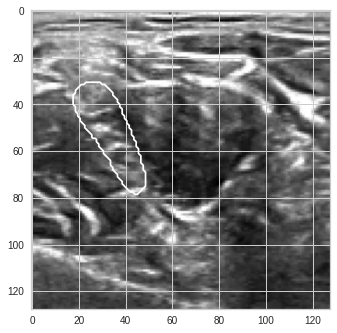

array([0., 1.], dtype=float32)

In [ ]:
i,j = next(test_gen)
print('Shape_in: {}'.format(i.shape))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
np.unique(j[0,:,:,0])

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
UPSAMPLE_MODE = 'SIMPLE' # SIMPLE'
NET_SCALING = None
GAUSSIAN_NOISE = 0.1
EDGE_CROP = 16
ACTIVATION = 'relu'
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_model(phi_units = 128):
  input_img = layers.Input((width,height,3), name = 'RGB_Input')
  pp_in_layer = input_img
  if NET_SCALING is not None:
      pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
      
  # pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
  pp_in_layer = layers.BatchNormalization()(pp_in_layer)

  c1 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (pp_in_layer)
  c1 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (c1)
  p1 = layers.MaxPooling2D((2, 2)) (c1)

  c2 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (p1)
  c2 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (c2)
  p2 = layers.MaxPooling2D((2, 2)) (c2)

  c3 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (p2)
  c3 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (c3)
  p3 = layers.MaxPooling2D((2, 2)) (c3)

  c4 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (p3)
  c4 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (c4)
  p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (p4)
  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (c5)

  u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = layers.concatenate([u6, c4])
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (u6)
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (c6)

  u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = layers.concatenate([u7, c3])
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (u7)
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (c7)

  u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = layers.concatenate([u8, c2])
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (u8)
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (c8)

  u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = layers.concatenate([u9, c1], axis=3)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (u9)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (c9)

  d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
  d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
  d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP),name='output')(d)
  if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)

  seg_model = models.Model(inputs=[input_img], outputs=[d])
  
  return seg_model

seg_model = create_model(65)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
______________________________________________________________________________________________

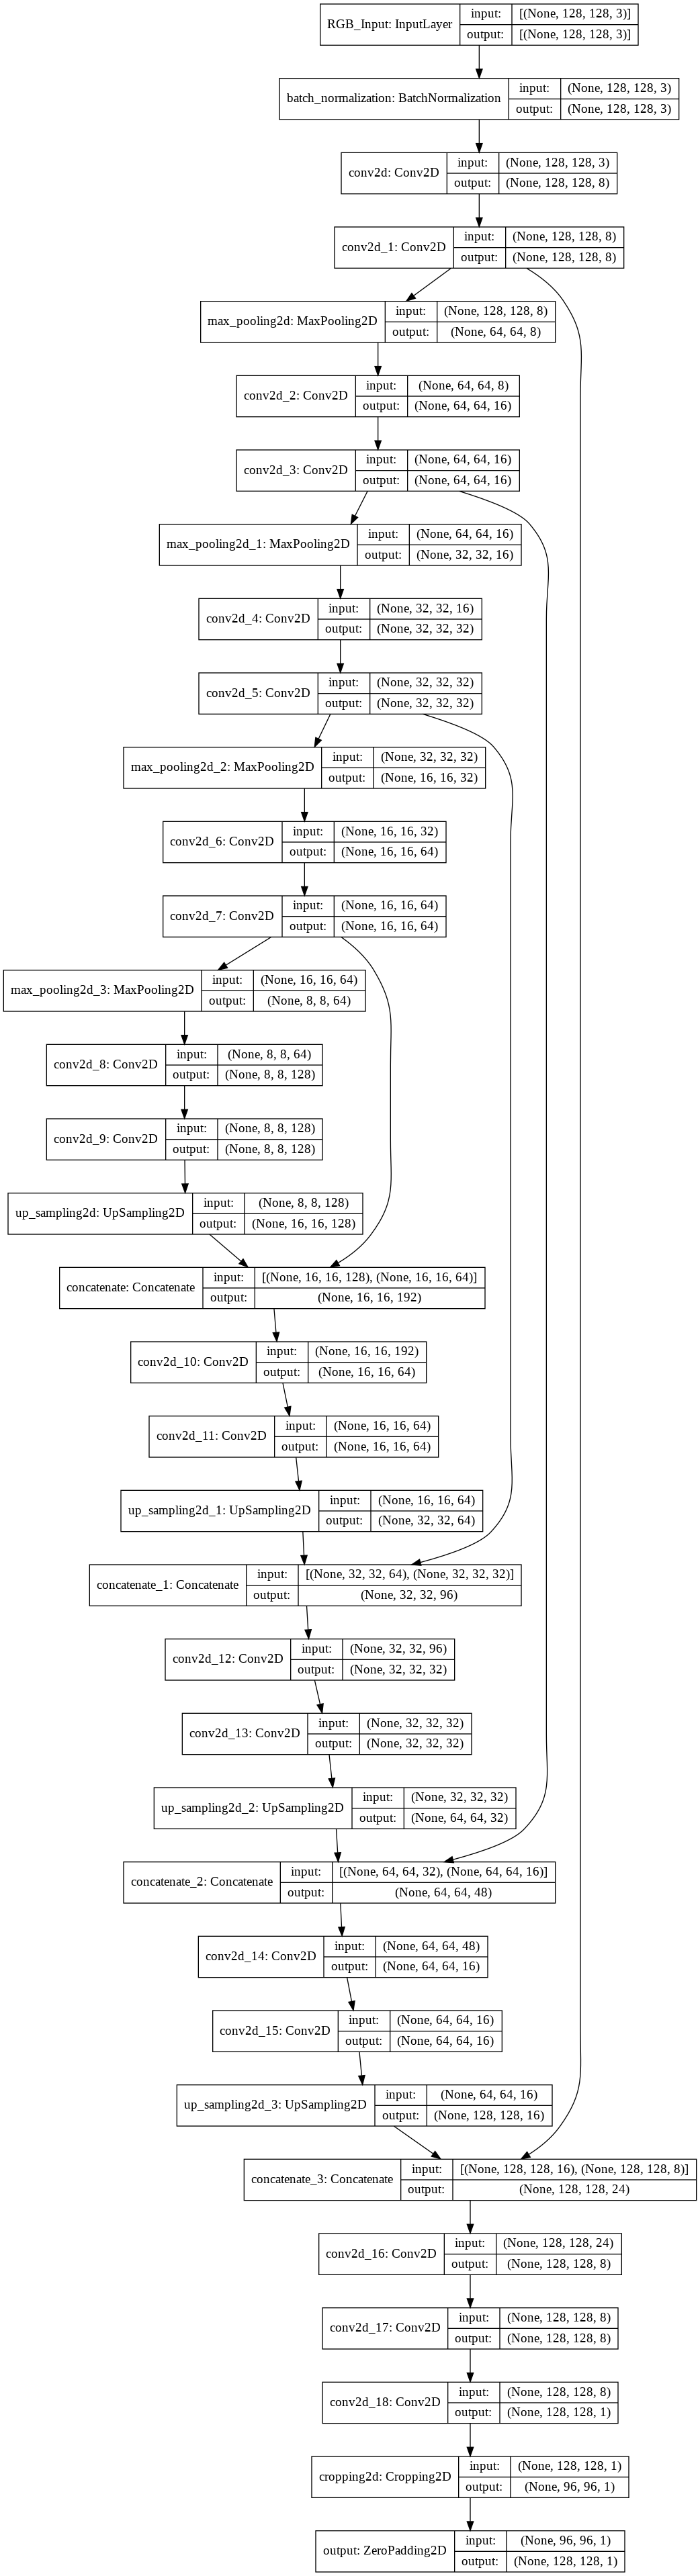

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 35s 399ms/step - loss: -0.1054 - iou: 0.0557 - dice_coef: 0.1054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4852 - val_loss: -0.1122 - val_iou: 0.0595 - val_dice_coef: 0.1122 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4699


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 18s 386ms/step - loss: -0.1397 - iou: 0.0750 - dice_coef: 0.1395 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4737 - val_loss: -0.1392 - val_iou: 0.0748 - val_dice_coef: 0.1392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5105


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 18s 395ms/step - loss: -0.1493 - iou: 0.0806 - dice_coef: 0.1491 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6416 - val_loss: -0.1490 - val_iou: 0.0805 - val_dice_coef: 0.1490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.7882


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 410ms/step - loss: -0.1573 - iou: 0.0865 - dice_coef: 0.1571 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8678 - val_loss: -5.0145e-04 - val_iou: 2.7920e-04 - val_dice_coef: 5.0145e-04 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 413ms/step - loss: -5.9143e-05 - iou: 6.0049e-05 - dice_coef: 6.0060e-05 - sensitivity: 0.3132 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7967e-05 - val_iou: 5.7967e-05 - val_dice_coef: 5.7967e-05 - val_sensitivity: 0.9801 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 18s 405ms/step - loss: -5.9520e-05 - iou: 6.0399e-05 - dice_coef: 6.0399e-05 - sensitivity: 0.0262 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7802e-05 - val_iou: 5.7802e-05 - val_dice_coef: 5.7802e-05 - val_sensitivity: 0.8750 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9626e-05 - iou: 6.0647e-05 - dice_coef: 6.0647e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7690e-05 - val_iou: 5.7690e-05 - val_dice_coef: 5.7690e-05 - val_sensitivity: 0.5909 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9130e-05 - iou: 6.0030e-05 - dice_coef: 6.0030e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7296e-05 - val_iou: 5.7296e-05 - val_dice_coef: 5.7296e-05 - val_sensitivity: 0.2926 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9466e-05 - iou: 6.0380e-05 - dice_coef: 6.0380e-05 - sensitivity: 0.0235 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7790e-05 - val_iou: 5.7790e-05 - val_dice_coef: 5.7790e-05 - val_sensitivity: 0.1364 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9652e-05 - iou: 6.0681e-05 - dice_coef: 6.0681e-05 - sensitivity: 0.0109 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7537e-05 - val_iou: 5.7537e-05 - val_dice_coef: 5.7537e-05 - val_sensitivity: 0.0966 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9233e-05 - iou: 6.0180e-05 - dice_coef: 6.0180e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7951e-05 - val_iou: 5.7951e-05 - val_dice_coef: 5.7951e-05 - val_sensitivity: 0.0455 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 397ms/step - loss: -5.9423e-05 - iou: 6.0195e-05 - dice_coef: 6.0195e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7654e-05 - val_iou: 5.7654e-05 - val_dice_coef: 5.7654e-05 - val_sensitivity: 0.0398 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9064e-05 - iou: 5.9993e-05 - dice_coef: 5.9993e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7760e-05 - val_iou: 5.7760e-05 - val_dice_coef: 5.7760e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9387e-05 - iou: 6.0235e-05 - dice_coef: 6.0235e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7739e-05 - val_iou: 5.7739e-05 - val_dice_coef: 5.7739e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 402ms/step - loss: -5.9678e-05 - iou: 6.0675e-05 - dice_coef: 6.0675e-05 - sensitivity: 0.0129 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.8016e-05 - val_iou: 5.8016e-05 - val_dice_coef: 5.8016e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9368e-05 - iou: 6.0252e-05 - dice_coef: 6.0252e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7705e-05 - val_iou: 5.7705e-05 - val_dice_coef: 5.7705e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 425ms/step - loss: -5.9351e-05 - iou: 6.0215e-05 - dice_coef: 6.0215e-05 - sensitivity: 0.0217 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7779e-05 - val_iou: 5.7779e-05 - val_dice_coef: 5.7779e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 18s 404ms/step - loss: -5.9269e-05 - iou: 6.0060e-05 - dice_coef: 6.0060e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7680e-05 - val_iou: 5.7680e-05 - val_dice_coef: 5.7680e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9566e-05 - iou: 6.0518e-05 - dice_coef: 6.0518e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7819e-05 - val_iou: 5.7819e-05 - val_dice_coef: 5.7819e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9260e-05 - iou: 6.0069e-05 - dice_coef: 6.0069e-05 - sensitivity: 0.0217 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.8028e-05 - val_iou: 5.8028e-05 - val_dice_coef: 5.8028e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 18s 404ms/step - loss: -5.9035e-05 - iou: 5.9793e-05 - dice_coef: 5.9793e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.8023e-05 - val_iou: 5.8023e-05 - val_dice_coef: 5.8023e-05 - val_sensitivity: 0.0398 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9581e-05 - iou: 6.0415e-05 - dice_coef: 6.0415e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7828e-05 - val_iou: 5.7828e-05 - val_dice_coef: 5.7828e-05 - val_sensitivity: 0.0398 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 415ms/step - loss: -5.9547e-05 - iou: 6.0306e-05 - dice_coef: 6.0306e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7603e-05 - val_iou: 5.7603e-05 - val_dice_coef: 5.7603e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 402ms/step - loss: -5.9242e-05 - iou: 6.0093e-05 - dice_coef: 6.0093e-05 - sensitivity: 0.0217 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.8242e-05 - val_iou: 5.8242e-05 - val_dice_coef: 5.8242e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 411ms/step - loss: -5.9761e-05 - iou: 6.0821e-05 - dice_coef: 6.0821e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7474e-05 - val_iou: 5.7474e-05 - val_dice_coef: 5.7474e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 416ms/step - loss: -5.9374e-05 - iou: 6.0214e-05 - dice_coef: 6.0214e-05 - sensitivity: 0.0149 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7475e-05 - val_iou: 5.7475e-05 - val_dice_coef: 5.7475e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 402ms/step - loss: -5.9028e-05 - iou: 5.9792e-05 - dice_coef: 5.9792e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7813e-05 - val_iou: 5.7813e-05 - val_dice_coef: 5.7813e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 397ms/step - loss: -5.9266e-05 - iou: 5.9984e-05 - dice_coef: 5.9984e-05 - sensitivity: 0.0213 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7660e-05 - val_iou: 5.7660e-05 - val_dice_coef: 5.7660e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 18s 404ms/step - loss: -5.9731e-05 - iou: 6.0827e-05 - dice_coef: 6.0827e-05 - sensitivity: 0.0149 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7636e-05 - val_iou: 5.7636e-05 - val_dice_coef: 5.7636e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9478e-05 - iou: 6.0269e-05 - dice_coef: 6.0269e-05 - sensitivity: 0.0131 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7454e-05 - val_iou: 5.7454e-05 - val_dice_coef: 5.7454e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 395ms/step - loss: -5.8909e-05 - iou: 5.9906e-05 - dice_coef: 5.9906e-05 - sensitivity: 0.0224 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7796e-05 - val_iou: 5.7796e-05 - val_dice_coef: 5.7796e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9942e-05 - iou: 6.0868e-05 - dice_coef: 6.0868e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9677 - val_loss: -5.7748e-05 - val_iou: 5.7748e-05 - val_dice_coef: 5.7748e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9380e-05 - iou: 6.0391e-05 - dice_coef: 6.0391e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7956e-05 - val_iou: 5.7956e-05 - val_dice_coef: 5.7956e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9127e-05 - iou: 5.9928e-05 - dice_coef: 5.9928e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7763e-05 - val_iou: 5.7763e-05 - val_dice_coef: 5.7763e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 18s 400ms/step - loss: -5.9463e-05 - iou: 6.0281e-05 - dice_coef: 6.0281e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7789e-05 - val_iou: 5.7789e-05 - val_dice_coef: 5.7789e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 18s 398ms/step - loss: -5.9363e-05 - iou: 6.0173e-05 - dice_coef: 6.0173e-05 - sensitivity: 0.0224 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7798e-05 - val_iou: 5.7798e-05 - val_dice_coef: 5.7798e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 402ms/step - loss: -5.9382e-05 - iou: 6.0374e-05 - dice_coef: 6.0374e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7570e-05 - val_iou: 5.7570e-05 - val_dice_coef: 5.7570e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 399ms/step - loss: -5.9792e-05 - iou: 6.0843e-05 - dice_coef: 6.0843e-05 - sensitivity: 0.0194 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7540e-05 - val_iou: 5.7540e-05 - val_dice_coef: 5.7540e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9028e-05 - iou: 5.9906e-05 - dice_coef: 5.9906e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7846e-05 - val_iou: 5.7846e-05 - val_dice_coef: 5.7846e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9755e-05 - iou: 6.0810e-05 - dice_coef: 6.0810e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7746e-05 - val_iou: 5.7746e-05 - val_dice_coef: 5.7746e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9350e-05 - iou: 6.0219e-05 - dice_coef: 6.0219e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7371e-05 - val_iou: 5.7371e-05 - val_dice_coef: 5.7371e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 18s 389ms/step - loss: -5.8935e-05 - iou: 5.9867e-05 - dice_coef: 5.9867e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7561e-05 - val_iou: 5.7561e-05 - val_dice_coef: 5.7561e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9603e-05 - iou: 6.0560e-05 - dice_coef: 6.0560e-05 - sensitivity: 0.0235 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7725e-05 - val_iou: 5.7725e-05 - val_dice_coef: 5.7725e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 425ms/step - loss: -5.9762e-05 - iou: 6.0786e-05 - dice_coef: 6.0786e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7817e-05 - val_iou: 5.7817e-05 - val_dice_coef: 5.7817e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9356e-05 - iou: 6.0221e-05 - dice_coef: 6.0221e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7739e-05 - val_iou: 5.7739e-05 - val_dice_coef: 5.7739e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9348e-05 - iou: 6.0171e-05 - dice_coef: 6.0171e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7711e-05 - val_iou: 5.7711e-05 - val_dice_coef: 5.7711e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9296e-05 - iou: 6.0076e-05 - dice_coef: 6.0076e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7332e-05 - val_iou: 5.7332e-05 - val_dice_coef: 5.7332e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9666


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 18s 397ms/step - loss: -5.8686e-05 - iou: 5.8686e-05 - dice_coef: 5.8686e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7826e-05 - val_iou: 5.7826e-05 - val_dice_coef: 5.7826e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 18s 398ms/step - loss: -5.9317e-05 - iou: 6.0166e-05 - dice_coef: 6.0166e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7899e-05 - val_iou: 5.7899e-05 - val_dice_coef: 5.7899e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9644e-05 - iou: 6.0756e-05 - dice_coef: 6.0756e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7547e-05 - val_iou: 5.7547e-05 - val_dice_coef: 5.7547e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9275e-05 - iou: 6.0232e-05 - dice_coef: 6.0232e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7880e-05 - val_iou: 5.7880e-05 - val_dice_coef: 5.7880e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9253e-05 - iou: 6.0111e-05 - dice_coef: 6.0111e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7458e-05 - val_iou: 5.7458e-05 - val_dice_coef: 5.7458e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 18s 400ms/step - loss: -5.9722e-05 - iou: 6.0683e-05 - dice_coef: 6.0683e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7648e-05 - val_iou: 5.7648e-05 - val_dice_coef: 5.7648e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9168e-05 - iou: 6.0066e-05 - dice_coef: 6.0066e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7593e-05 - val_iou: 5.7593e-05 - val_dice_coef: 5.7593e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9619e-05 - iou: 6.0658e-05 - dice_coef: 6.0658e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8297e-05 - val_iou: 5.8297e-05 - val_dice_coef: 5.8297e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9469e-05 - iou: 6.0391e-05 - dice_coef: 6.0391e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7636e-05 - val_iou: 5.7636e-05 - val_dice_coef: 5.7636e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9435e-05 - iou: 6.0140e-05 - dice_coef: 6.0140e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7543e-05 - val_iou: 5.7543e-05 - val_dice_coef: 5.7543e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9501e-05 - iou: 6.0506e-05 - dice_coef: 6.0506e-05 - sensitivity: 0.0172 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7997e-05 - val_iou: 5.7997e-05 - val_dice_coef: 5.7997e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9213e-05 - iou: 6.0160e-05 - dice_coef: 6.0160e-05 - sensitivity: 0.0217 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7772e-05 - val_iou: 5.7772e-05 - val_dice_coef: 5.7772e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9505e-05 - iou: 6.0331e-05 - dice_coef: 6.0331e-05 - sensitivity: 0.0199 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7797e-05 - val_iou: 5.7797e-05 - val_dice_coef: 5.7797e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9310e-05 - iou: 6.0300e-05 - dice_coef: 6.0300e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7887e-05 - val_iou: 5.7887e-05 - val_dice_coef: 5.7887e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9700e-05 - iou: 6.0786e-05 - dice_coef: 6.0786e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.8005e-05 - val_iou: 5.8005e-05 - val_dice_coef: 5.8005e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9103e-05 - iou: 5.9856e-05 - dice_coef: 5.9856e-05 - sensitivity: 0.0214 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7879e-05 - val_iou: 5.7879e-05 - val_dice_coef: 5.7879e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9653e-05 - iou: 6.0487e-05 - dice_coef: 6.0487e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7725e-05 - val_iou: 5.7725e-05 - val_dice_coef: 5.7725e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9131e-05 - iou: 6.0148e-05 - dice_coef: 6.0148e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7455e-05 - val_iou: 5.7455e-05 - val_dice_coef: 5.7455e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9467e-05 - iou: 6.0408e-05 - dice_coef: 6.0408e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8034e-05 - val_iou: 5.8034e-05 - val_dice_coef: 5.8034e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9553e-05 - iou: 6.0565e-05 - dice_coef: 6.0565e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7841e-05 - val_iou: 5.7841e-05 - val_dice_coef: 5.7841e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9037e-05 - iou: 5.9810e-05 - dice_coef: 5.9810e-05 - sensitivity: 0.0233 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7989e-05 - val_iou: 5.7989e-05 - val_dice_coef: 5.7989e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9496e-05 - iou: 6.0387e-05 - dice_coef: 6.0387e-05 - sensitivity: 0.0109 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7678e-05 - val_iou: 5.7678e-05 - val_dice_coef: 5.7678e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9524e-05 - iou: 6.0424e-05 - dice_coef: 6.0424e-05 - sensitivity: 0.0238 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7821e-05 - val_iou: 5.7821e-05 - val_dice_coef: 5.7821e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9196e-05 - iou: 6.0176e-05 - dice_coef: 6.0176e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7511e-05 - val_iou: 5.7511e-05 - val_dice_coef: 5.7511e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9632e-05 - iou: 6.0629e-05 - dice_coef: 6.0629e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7782e-05 - val_iou: 5.7782e-05 - val_dice_coef: 5.7782e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9414e-05 - iou: 6.0398e-05 - dice_coef: 6.0398e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7994e-05 - val_iou: 5.7994e-05 - val_dice_coef: 5.7994e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9100e-05 - iou: 5.9962e-05 - dice_coef: 5.9962e-05 - sensitivity: 0.0167 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7939e-05 - val_iou: 5.7939e-05 - val_dice_coef: 5.7939e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9810e-05 - iou: 6.0947e-05 - dice_coef: 6.0947e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7840e-05 - val_iou: 5.7840e-05 - val_dice_coef: 5.7840e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9058e-05 - iou: 5.9906e-05 - dice_coef: 5.9906e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7513e-05 - val_iou: 5.7513e-05 - val_dice_coef: 5.7513e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9422e-05 - iou: 6.0497e-05 - dice_coef: 6.0497e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7709e-05 - val_iou: 5.7709e-05 - val_dice_coef: 5.7709e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9647e-05 - iou: 6.0521e-05 - dice_coef: 6.0521e-05 - sensitivity: 0.0224 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7851e-05 - val_iou: 5.7851e-05 - val_dice_coef: 5.7851e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9567e-05 - iou: 6.0555e-05 - dice_coef: 6.0555e-05 - sensitivity: 0.0238 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8102e-05 - val_iou: 5.8102e-05 - val_dice_coef: 5.8102e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 17s 385ms/step - loss: -5.9119e-05 - iou: 6.0082e-05 - dice_coef: 6.0082e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7876e-05 - val_iou: 5.7876e-05 - val_dice_coef: 5.7876e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9800e-05 - iou: 6.0765e-05 - dice_coef: 6.0765e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7388e-05 - val_iou: 5.7388e-05 - val_dice_coef: 5.7388e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9391e-05 - iou: 6.0477e-05 - dice_coef: 6.0477e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7707e-05 - val_iou: 5.7707e-05 - val_dice_coef: 5.7707e-05 - val_sensitivity: 0.0114 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9244e-05 - iou: 6.0101e-05 - dice_coef: 6.0101e-05 - sensitivity: 0.0258 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7485e-05 - val_iou: 5.7485e-05 - val_dice_coef: 5.7485e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9560e-05 - iou: 6.0372e-05 - dice_coef: 6.0372e-05 - sensitivity: 0.0151 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7381e-05 - val_iou: 5.7381e-05 - val_dice_coef: 5.7381e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9420e-05 - iou: 6.0214e-05 - dice_coef: 6.0214e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7909e-05 - val_iou: 5.7909e-05 - val_dice_coef: 5.7909e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9310e-05 - iou: 6.0302e-05 - dice_coef: 6.0302e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7360e-05 - val_iou: 5.7360e-05 - val_dice_coef: 5.7360e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9789e-05 - iou: 6.0825e-05 - dice_coef: 6.0825e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7782e-05 - val_iou: 5.7782e-05 - val_dice_coef: 5.7782e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 17s 384ms/step - loss: -5.8976e-05 - iou: 5.9783e-05 - dice_coef: 5.9783e-05 - sensitivity: 0.0206 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7909e-05 - val_iou: 5.7909e-05 - val_dice_coef: 5.7909e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9463e-05 - iou: 6.0477e-05 - dice_coef: 6.0477e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7472e-05 - val_iou: 5.7472e-05 - val_dice_coef: 5.7472e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9478e-05 - iou: 6.0488e-05 - dice_coef: 6.0488e-05 - sensitivity: 0.0238 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7552e-05 - val_iou: 5.7552e-05 - val_dice_coef: 5.7552e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 17s 385ms/step - loss: -5.9268e-05 - iou: 5.9970e-05 - dice_coef: 5.9970e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7644e-05 - val_iou: 5.7644e-05 - val_dice_coef: 5.7644e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9484e-05 - iou: 6.0370e-05 - dice_coef: 6.0370e-05 - sensitivity: 0.0226 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7588e-05 - val_iou: 5.7588e-05 - val_dice_coef: 5.7588e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9272e-05 - iou: 6.0231e-05 - dice_coef: 6.0231e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7555e-05 - val_iou: 5.7555e-05 - val_dice_coef: 5.7555e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9412e-05 - iou: 6.0203e-05 - dice_coef: 6.0203e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7699e-05 - val_iou: 5.7699e-05 - val_dice_coef: 5.7699e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 18s 395ms/step - loss: -5.8652e-05 - iou: 5.8652e-05 - dice_coef: 5.8652e-05 - sensitivity: 0.0122 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.8123e-05 - val_iou: 5.8123e-05 - val_dice_coef: 5.8123e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9445e-05 - iou: 6.0410e-05 - dice_coef: 6.0410e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7550e-05 - val_iou: 5.7550e-05 - val_dice_coef: 5.7550e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9445e-05 - iou: 6.0321e-05 - dice_coef: 6.0321e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7538e-05 - val_iou: 5.7538e-05 - val_dice_coef: 5.7538e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9294e-05 - iou: 6.0103e-05 - dice_coef: 6.0103e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.8102e-05 - val_iou: 5.8102e-05 - val_dice_coef: 5.8102e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9358e-05 - iou: 6.0253e-05 - dice_coef: 6.0253e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7771e-05 - val_iou: 5.7771e-05 - val_dice_coef: 5.7771e-05 - val_sensitivity: 0.0114 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9653e-05 - iou: 6.0481e-05 - dice_coef: 6.0481e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7946e-05 - val_iou: 5.7946e-05 - val_dice_coef: 5.7946e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9235e-05 - iou: 6.0179e-05 - dice_coef: 6.0179e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7531e-05 - val_iou: 5.7531e-05 - val_dice_coef: 5.7531e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9302e-05 - iou: 6.0294e-05 - dice_coef: 6.0294e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7948e-05 - val_iou: 5.7948e-05 - val_dice_coef: 5.7948e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9499e-05 - iou: 6.0411e-05 - dice_coef: 6.0411e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7883e-05 - val_iou: 5.7883e-05 - val_dice_coef: 5.7883e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9584e-05 - iou: 6.0524e-05 - dice_coef: 6.0524e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7667e-05 - val_iou: 5.7667e-05 - val_dice_coef: 5.7667e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9400e-05 - iou: 6.0311e-05 - dice_coef: 6.0311e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7691e-05 - val_iou: 5.7691e-05 - val_dice_coef: 5.7691e-05 - val_sensitivity: 0.0085 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9452e-05 - iou: 6.0536e-05 - dice_coef: 6.0536e-05 - sensitivity: 0.0265 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7467e-05 - val_iou: 5.7467e-05 - val_dice_coef: 5.7467e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9223e-05 - iou: 6.0164e-05 - dice_coef: 6.0164e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7515e-05 - val_iou: 5.7515e-05 - val_dice_coef: 5.7515e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9659e-05 - iou: 6.0620e-05 - dice_coef: 6.0620e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7878e-05 - val_iou: 5.7878e-05 - val_dice_coef: 5.7878e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9176e-05 - iou: 6.0109e-05 - dice_coef: 6.0109e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7708e-05 - val_iou: 5.7708e-05 - val_dice_coef: 5.7708e-05 - val_sensitivity: 0.0426 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9329e-05 - iou: 6.0253e-05 - dice_coef: 6.0253e-05 - sensitivity: 0.0258 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7920e-05 - val_iou: 5.7920e-05 - val_dice_coef: 5.7920e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9705e-05 - iou: 6.0542e-05 - dice_coef: 6.0542e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7548e-05 - val_iou: 5.7548e-05 - val_dice_coef: 5.7548e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 18s 389ms/step - loss: -5.8906e-05 - iou: 5.9777e-05 - dice_coef: 5.9777e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.8070e-05 - val_iou: 5.8070e-05 - val_dice_coef: 5.8070e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9749e-05 - iou: 6.0504e-05 - dice_coef: 6.0504e-05 - sensitivity: 0.0138 - specificity: 0.0000e+00 - binary_accuracy: 0.9677 - val_loss: -5.8118e-05 - val_iou: 5.8118e-05 - val_dice_coef: 5.8118e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9063e-05 - iou: 6.0079e-05 - dice_coef: 6.0079e-05 - sensitivity: 0.0258 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.8034e-05 - val_iou: 5.8034e-05 - val_dice_coef: 5.8034e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9643e-05 - iou: 6.0573e-05 - dice_coef: 6.0573e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7622e-05 - val_iou: 5.7622e-05 - val_dice_coef: 5.7622e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9141e-05 - iou: 5.9977e-05 - dice_coef: 5.9977e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7785e-05 - val_iou: 5.7785e-05 - val_dice_coef: 5.7785e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9555e-05 - iou: 6.0359e-05 - dice_coef: 6.0359e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7441e-05 - val_iou: 5.7441e-05 - val_dice_coef: 5.7441e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 17s 386ms/step - loss: -5.8988e-05 - iou: 5.9797e-05 - dice_coef: 5.9797e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7570e-05 - val_iou: 5.7570e-05 - val_dice_coef: 5.7570e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9875e-05 - iou: 6.0647e-05 - dice_coef: 6.0647e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9677 - val_loss: -5.7780e-05 - val_iou: 5.7780e-05 - val_dice_coef: 5.7780e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9424e-05 - iou: 6.0379e-05 - dice_coef: 6.0379e-05 - sensitivity: 0.0149 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7942e-05 - val_iou: 5.7942e-05 - val_dice_coef: 5.7942e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9260e-05 - iou: 6.0018e-05 - dice_coef: 6.0018e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7711e-05 - val_iou: 5.7711e-05 - val_dice_coef: 5.7711e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9373e-05 - iou: 6.0404e-05 - dice_coef: 6.0404e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7651e-05 - val_iou: 5.7651e-05 - val_dice_coef: 5.7651e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 17s 384ms/step - loss: -5.9354e-05 - iou: 6.0345e-05 - dice_coef: 6.0345e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7483e-05 - val_iou: 5.7483e-05 - val_dice_coef: 5.7483e-05 - val_sensitivity: 0.0455 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9682e-05 - iou: 6.0860e-05 - dice_coef: 6.0860e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7838e-05 - val_iou: 5.7838e-05 - val_dice_coef: 5.7838e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9196e-05 - iou: 6.0197e-05 - dice_coef: 6.0197e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7916e-05 - val_iou: 5.7916e-05 - val_dice_coef: 5.7916e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9049e-05 - iou: 5.9903e-05 - dice_coef: 5.9903e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7757e-05 - val_iou: 5.7757e-05 - val_dice_coef: 5.7757e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9524e-05 - iou: 6.0376e-05 - dice_coef: 6.0376e-05 - sensitivity: 0.0233 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7583e-05 - val_iou: 5.7583e-05 - val_dice_coef: 5.7583e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9880e-05 - iou: 6.0985e-05 - dice_coef: 6.0985e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7627e-05 - val_iou: 5.7627e-05 - val_dice_coef: 5.7627e-05 - val_sensitivity: 0.0085 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9318e-05 - iou: 6.0129e-05 - dice_coef: 6.0129e-05 - sensitivity: 0.0192 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7562e-05 - val_iou: 5.7562e-05 - val_dice_coef: 5.7562e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9111e-05 - iou: 5.9938e-05 - dice_coef: 5.9938e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7232e-05 - val_iou: 5.7232e-05 - val_dice_coef: 5.7232e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9666


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 17s 385ms/step - loss: -5.9463e-05 - iou: 6.0360e-05 - dice_coef: 6.0360e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7935e-05 - val_iou: 5.7935e-05 - val_dice_coef: 5.7935e-05 - val_sensitivity: 0.0369 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9577e-05 - iou: 6.0466e-05 - dice_coef: 6.0466e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7616e-05 - val_iou: 5.7616e-05 - val_dice_coef: 5.7616e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9184e-05 - iou: 6.0115e-05 - dice_coef: 6.0115e-05 - sensitivity: 0.0149 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7907e-05 - val_iou: 5.7907e-05 - val_dice_coef: 5.7907e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 17s 385ms/step - loss: -5.9621e-05 - iou: 6.0418e-05 - dice_coef: 6.0418e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7469e-05 - val_iou: 5.7469e-05 - val_dice_coef: 5.7469e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9210e-05 - iou: 6.0016e-05 - dice_coef: 6.0016e-05 - sensitivity: 0.0224 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.8103e-05 - val_iou: 5.8103e-05 - val_dice_coef: 5.8103e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9302e-05 - iou: 6.0122e-05 - dice_coef: 6.0122e-05 - sensitivity: 0.0129 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7614e-05 - val_iou: 5.7614e-05 - val_dice_coef: 5.7614e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9608e-05 - iou: 6.0535e-05 - dice_coef: 6.0535e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7888e-05 - val_iou: 5.7888e-05 - val_dice_coef: 5.7888e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9330e-05 - iou: 6.0311e-05 - dice_coef: 6.0311e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7840e-05 - val_iou: 5.7840e-05 - val_dice_coef: 5.7840e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 17s 385ms/step - loss: -5.9506e-05 - iou: 6.0515e-05 - dice_coef: 6.0515e-05 - sensitivity: 0.0172 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7579e-05 - val_iou: 5.7579e-05 - val_dice_coef: 5.7579e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9388e-05 - iou: 6.0396e-05 - dice_coef: 6.0396e-05 - sensitivity: 0.0165 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7612e-05 - val_iou: 5.7612e-05 - val_dice_coef: 5.7612e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 18s 398ms/step - loss: -5.9308e-05 - iou: 6.0107e-05 - dice_coef: 6.0107e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7788e-05 - val_iou: 5.7788e-05 - val_dice_coef: 5.7788e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 393ms/step - loss: -5.8698e-05 - iou: 5.8698e-05 - dice_coef: 5.8698e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7536e-05 - val_iou: 5.7536e-05 - val_dice_coef: 5.7536e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9243e-05 - iou: 6.0046e-05 - dice_coef: 6.0046e-05 - sensitivity: 0.0156 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7568e-05 - val_iou: 5.7568e-05 - val_dice_coef: 5.7568e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9534e-05 - iou: 6.0580e-05 - dice_coef: 6.0580e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7554e-05 - val_iou: 5.7554e-05 - val_dice_coef: 5.7554e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9615e-05 - iou: 6.0402e-05 - dice_coef: 6.0402e-05 - sensitivity: 0.0129 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7339e-05 - val_iou: 5.7339e-05 - val_dice_coef: 5.7339e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9114e-05 - iou: 5.9897e-05 - dice_coef: 5.9897e-05 - sensitivity: 0.0185 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7972e-05 - val_iou: 5.7972e-05 - val_dice_coef: 5.7972e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9457e-05 - iou: 6.0341e-05 - dice_coef: 6.0341e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7635e-05 - val_iou: 5.7635e-05 - val_dice_coef: 5.7635e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9599e-05 - iou: 6.0585e-05 - dice_coef: 6.0585e-05 - sensitivity: 0.0253 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7472e-05 - val_iou: 5.7472e-05 - val_dice_coef: 5.7472e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 18s 395ms/step - loss: -5.8821e-05 - iou: 5.9630e-05 - dice_coef: 5.9630e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9671 - val_loss: -5.7648e-05 - val_iou: 5.7648e-05 - val_dice_coef: 5.7648e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9650e-05 - iou: 6.0628e-05 - dice_coef: 6.0628e-05 - sensitivity: 0.0192 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7977e-05 - val_iou: 5.7977e-05 - val_dice_coef: 5.7977e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9402e-05 - iou: 6.0214e-05 - dice_coef: 6.0214e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7614e-05 - val_iou: 5.7614e-05 - val_dice_coef: 5.7614e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9227e-05 - iou: 6.0044e-05 - dice_coef: 6.0044e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7765e-05 - val_iou: 5.7765e-05 - val_dice_coef: 5.7765e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9375e-05 - iou: 6.0222e-05 - dice_coef: 6.0222e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8009e-05 - val_iou: 5.8009e-05 - val_dice_coef: 5.8009e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9686e-05 - iou: 6.0679e-05 - dice_coef: 6.0679e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7549e-05 - val_iou: 5.7549e-05 - val_dice_coef: 5.7549e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9058e-05 - iou: 5.9860e-05 - dice_coef: 5.9860e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7660e-05 - val_iou: 5.7660e-05 - val_dice_coef: 5.7660e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9392e-05 - iou: 6.0144e-05 - dice_coef: 6.0144e-05 - sensitivity: 0.0170 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7566e-05 - val_iou: 5.7566e-05 - val_dice_coef: 5.7566e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9266e-05 - iou: 6.0093e-05 - dice_coef: 6.0093e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7747e-05 - val_iou: 5.7747e-05 - val_dice_coef: 5.7747e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9527e-05 - iou: 6.0439e-05 - dice_coef: 6.0439e-05 - sensitivity: 0.0238 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7705e-05 - val_iou: 5.7705e-05 - val_dice_coef: 5.7705e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9405e-05 - iou: 6.0198e-05 - dice_coef: 6.0198e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7596e-05 - val_iou: 5.7596e-05 - val_dice_coef: 5.7596e-05 - val_sensitivity: 0.0341 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 18s 388ms/step - loss: -5.9574e-05 - iou: 6.0586e-05 - dice_coef: 6.0586e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7903e-05 - val_iou: 5.7903e-05 - val_dice_coef: 5.7903e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 17s 386ms/step - loss: -5.8952e-05 - iou: 5.9719e-05 - dice_coef: 5.9719e-05 - sensitivity: 0.0213 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -5.7921e-05 - val_iou: 5.7921e-05 - val_dice_coef: 5.7921e-05 - val_sensitivity: 0.0114 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9545e-05 - iou: 6.0378e-05 - dice_coef: 6.0378e-05 - sensitivity: 0.0217 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7596e-05 - val_iou: 5.7596e-05 - val_dice_coef: 5.7596e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9472e-05 - iou: 6.0265e-05 - dice_coef: 6.0265e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7583e-05 - val_iou: 5.7583e-05 - val_dice_coef: 5.7583e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9336e-05 - iou: 6.0338e-05 - dice_coef: 6.0338e-05 - sensitivity: 0.0238 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7814e-05 - val_iou: 5.7814e-05 - val_dice_coef: 5.7814e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9551e-05 - iou: 6.0437e-05 - dice_coef: 6.0437e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7842e-05 - val_iou: 5.7842e-05 - val_dice_coef: 5.7842e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9367e-05 - iou: 6.0214e-05 - dice_coef: 6.0214e-05 - sensitivity: 0.0206 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7965e-05 - val_iou: 5.7965e-05 - val_dice_coef: 5.7965e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9351e-05 - iou: 6.0147e-05 - dice_coef: 6.0147e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7921e-05 - val_iou: 5.7921e-05 - val_dice_coef: 5.7921e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9471e-05 - iou: 6.0342e-05 - dice_coef: 6.0342e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8014e-05 - val_iou: 5.8014e-05 - val_dice_coef: 5.8014e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 17s 386ms/step - loss: -5.9341e-05 - iou: 6.0131e-05 - dice_coef: 6.0131e-05 - sensitivity: 0.0115 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7502e-05 - val_iou: 5.7502e-05 - val_dice_coef: 5.7502e-05 - val_sensitivity: 0.0312 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9515e-05 - iou: 6.0459e-05 - dice_coef: 6.0459e-05 - sensitivity: 0.0199 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7804e-05 - val_iou: 5.7804e-05 - val_dice_coef: 5.7804e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9259e-05 - iou: 6.0176e-05 - dice_coef: 6.0176e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7495e-05 - val_iou: 5.7495e-05 - val_dice_coef: 5.7495e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9202e-05 - iou: 6.0029e-05 - dice_coef: 6.0029e-05 - sensitivity: 0.0199 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7736e-05 - val_iou: 5.7736e-05 - val_dice_coef: 5.7736e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 18s 402ms/step - loss: -5.9201e-05 - iou: 5.9958e-05 - dice_coef: 5.9958e-05 - sensitivity: 0.0226 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7662e-05 - val_iou: 5.7662e-05 - val_dice_coef: 5.7662e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9588e-05 - iou: 6.0355e-05 - dice_coef: 6.0355e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7674e-05 - val_iou: 5.7674e-05 - val_dice_coef: 5.7674e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9307e-05 - iou: 6.0227e-05 - dice_coef: 6.0227e-05 - sensitivity: 0.0274 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7522e-05 - val_iou: 5.7522e-05 - val_dice_coef: 5.7522e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9541e-05 - iou: 6.0505e-05 - dice_coef: 6.0505e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7518e-05 - val_iou: 5.7518e-05 - val_dice_coef: 5.7518e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9628e-05 - iou: 6.0630e-05 - dice_coef: 6.0630e-05 - sensitivity: 0.0109 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7810e-05 - val_iou: 5.7810e-05 - val_dice_coef: 5.7810e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9311e-05 - iou: 6.0291e-05 - dice_coef: 6.0291e-05 - sensitivity: 0.0253 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7578e-05 - val_iou: 5.7578e-05 - val_dice_coef: 5.7578e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 18s 397ms/step - loss: -5.9719e-05 - iou: 6.0651e-05 - dice_coef: 6.0651e-05 - sensitivity: 0.0163 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7692e-05 - val_iou: 5.7692e-05 - val_dice_coef: 5.7692e-05 - val_sensitivity: 0.0199 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 17s 387ms/step - loss: -5.8880e-05 - iou: 5.9895e-05 - dice_coef: 5.9895e-05 - sensitivity: 0.0136 - specificity: 0.0000e+00 - binary_accuracy: 0.9671 - val_loss: -5.7891e-05 - val_iou: 5.7891e-05 - val_dice_coef: 5.7891e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9516e-05 - iou: 6.0535e-05 - dice_coef: 6.0535e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7903e-05 - val_iou: 5.7903e-05 - val_dice_coef: 5.7903e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9472e-05 - iou: 6.0361e-05 - dice_coef: 6.0361e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7980e-05 - val_iou: 5.7980e-05 - val_dice_coef: 5.7980e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9417e-05 - iou: 6.0397e-05 - dice_coef: 6.0397e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7692e-05 - val_iou: 5.7692e-05 - val_dice_coef: 5.7692e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 18s 396ms/step - loss: -5.9266e-05 - iou: 5.9907e-05 - dice_coef: 5.9907e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7995e-05 - val_iou: 5.7995e-05 - val_dice_coef: 5.7995e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 392ms/step - loss: -5.9569e-05 - iou: 6.0363e-05 - dice_coef: 6.0363e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7786e-05 - val_iou: 5.7786e-05 - val_dice_coef: 5.7786e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9164e-05 - iou: 6.0074e-05 - dice_coef: 6.0074e-05 - sensitivity: 0.0219 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7912e-05 - val_iou: 5.7912e-05 - val_dice_coef: 5.7912e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 18s 394ms/step - loss: -5.9408e-05 - iou: 6.0400e-05 - dice_coef: 6.0400e-05 - sensitivity: 0.0231 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7507e-05 - val_iou: 5.7507e-05 - val_dice_coef: 5.7507e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9541e-05 - iou: 6.0639e-05 - dice_coef: 6.0639e-05 - sensitivity: 0.0158 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7436e-05 - val_iou: 5.7436e-05 - val_dice_coef: 5.7436e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 18s 394ms/step - loss: -5.8686e-05 - iou: 5.8686e-05 - dice_coef: 5.8686e-05 - sensitivity: 0.0204 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7637e-05 - val_iou: 5.7637e-05 - val_dice_coef: 5.7637e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 432ms/step - loss: -5.9426e-05 - iou: 6.0338e-05 - dice_coef: 6.0338e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7737e-05 - val_iou: 5.7737e-05 - val_dice_coef: 5.7737e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9293e-05 - iou: 6.0195e-05 - dice_coef: 6.0195e-05 - sensitivity: 0.0251 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7634e-05 - val_iou: 5.7634e-05 - val_dice_coef: 5.7634e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 391ms/step - loss: -5.9566e-05 - iou: 6.0473e-05 - dice_coef: 6.0473e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7774e-05 - val_iou: 5.7774e-05 - val_dice_coef: 5.7774e-05 - val_sensitivity: 0.0170 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 395ms/step - loss: -5.9060e-05 - iou: 5.9998e-05 - dice_coef: 5.9998e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7679e-05 - val_iou: 5.7679e-05 - val_dice_coef: 5.7679e-05 - val_sensitivity: 0.0398 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 17s 388ms/step - loss: -5.9680e-05 - iou: 6.0636e-05 - dice_coef: 6.0636e-05 - sensitivity: 0.0211 - specificity: 0.0000e+00 - binary_accuracy: 0.9676 - val_loss: -5.7634e-05 - val_iou: 5.7634e-05 - val_dice_coef: 5.7634e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 18s 393ms/step - loss: -5.9639e-05 - iou: 6.0677e-05 - dice_coef: 6.0677e-05 - sensitivity: 0.0143 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7697e-05 - val_iou: 5.7697e-05 - val_dice_coef: 5.7697e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 18s 390ms/step - loss: -5.9279e-05 - iou: 6.0268e-05 - dice_coef: 6.0268e-05 - sensitivity: 0.0197 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -5.7363e-05 - val_iou: 5.7363e-05 - val_dice_coef: 5.7363e-05 - val_sensitivity: 0.0284 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 17s 387ms/step - loss: -5.9408e-05 - iou: 6.0188e-05 - dice_coef: 6.0188e-05 - sensitivity: 0.0190 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.7663e-05 - val_iou: 5.7663e-05 - val_dice_coef: 5.7663e-05 - val_sensitivity: 0.0142 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 18s 397ms/step - loss: -5.9218e-05 - iou: 6.0045e-05 - dice_coef: 6.0045e-05 - sensitivity: 0.0183 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7749e-05 - val_iou: 5.7749e-05 - val_dice_coef: 5.7749e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9556e-05 - iou: 6.0549e-05 - dice_coef: 6.0549e-05 - sensitivity: 0.0224 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -5.8251e-05 - val_iou: 5.8251e-05 - val_dice_coef: 5.8251e-05 - val_sensitivity: 0.0256 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 18s 389ms/step - loss: -5.9226e-05 - iou: 6.0099e-05 - dice_coef: 6.0099e-05 - sensitivity: 0.0177 - specificity: 0.0000e+00 - binary_accuracy: 0.9674 - val_loss: -5.7873e-05 - val_iou: 5.7873e-05 - val_dice_coef: 5.7873e-05 - val_sensitivity: 0.0227 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9670


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


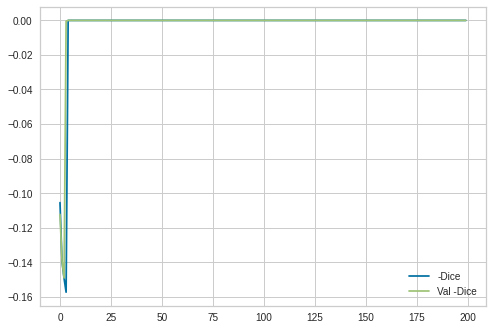

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 19s 396ms/step - loss: -0.1029 - iou: 0.0543 - dice_coef: 0.1029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9231 - val_loss: -0.1044 - val_iou: 0.0551 - val_dice_coef: 0.1044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9116


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 18s 404ms/step - loss: -0.1683 - iou: 0.0922 - dice_coef: 0.1678 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9346 - val_loss: -0.1839 - val_iou: 0.1013 - val_dice_coef: 0.1839 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9014


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 17s 386ms/step - loss: -0.2502 - iou: 0.1431 - dice_coef: 0.2501 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9367 - val_loss: -0.2250 - val_iou: 0.1269 - val_dice_coef: 0.2250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9369


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 395ms/step - loss: -0.2903 - iou: 0.1699 - dice_coef: 0.2899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9504 - val_loss: -0.2791 - val_iou: 0.1625 - val_dice_coef: 0.2791 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9583


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 18s 402ms/step - loss: -0.3240 - iou: 0.1941 - dice_coef: 0.3242 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9573 - val_loss: -0.3234 - val_iou: 0.1936 - val_dice_coef: 0.3234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9673


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 17s 387ms/step - loss: -0.3653 - iou: 0.2242 - dice_coef: 0.3652 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9645 - val_loss: -0.3676 - val_iou: 0.2259 - val_dice_coef: 0.3676 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9678


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4007 - iou: 0.2514 - dice_coef: 0.4008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9698 - val_loss: -0.4006 - val_iou: 0.2517 - val_dice_coef: 0.4006 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9701


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 394ms/step - loss: -0.4212 - iou: 0.2676 - dice_coef: 0.4214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9713 - val_loss: -0.4135 - val_iou: 0.2628 - val_dice_coef: 0.4135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9691


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 18s 390ms/step - loss: -0.4390 - iou: 0.2821 - dice_coef: 0.4388 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9729 - val_loss: -0.4263 - val_iou: 0.2719 - val_dice_coef: 0.4263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 18s 396ms/step - loss: -0.4418 - iou: 0.2850 - dice_coef: 0.4421 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9723 - val_loss: -0.4203 - val_iou: 0.2701 - val_dice_coef: 0.4203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 18s 396ms/step - loss: -0.4517 - iou: 0.2931 - dice_coef: 0.4518 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.4261 - val_iou: 0.2743 - val_dice_coef: 0.4261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9726


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 389ms/step - loss: -0.4589 - iou: 0.2985 - dice_coef: 0.4586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9747 - val_loss: -0.4497 - val_iou: 0.2906 - val_dice_coef: 0.4497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9721


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 18s 400ms/step - loss: -0.4605 - iou: 0.3002 - dice_coef: 0.4606 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9748 - val_loss: -0.4494 - val_iou: 0.2915 - val_dice_coef: 0.4494 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 404ms/step - loss: -0.4681 - iou: 0.3064 - dice_coef: 0.4677 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.4534 - val_iou: 0.2957 - val_dice_coef: 0.4534 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4660 - iou: 0.3051 - dice_coef: 0.4661 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.4476 - val_iou: 0.2917 - val_dice_coef: 0.4476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4697 - iou: 0.3077 - dice_coef: 0.4695 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.4498 - val_iou: 0.2935 - val_dice_coef: 0.4498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 17s 387ms/step - loss: -0.4805 - iou: 0.3178 - dice_coef: 0.4811 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9770 - val_loss: -0.4734 - val_iou: 0.3108 - val_dice_coef: 0.4734 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 18s 390ms/step - loss: -0.4796 - iou: 0.3163 - dice_coef: 0.4792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9763 - val_loss: -0.4727 - val_iou: 0.3107 - val_dice_coef: 0.4727 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4825 - iou: 0.3184 - dice_coef: 0.4818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -0.4565 - val_iou: 0.2993 - val_dice_coef: 0.4565 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 17s 388ms/step - loss: -0.4917 - iou: 0.3272 - dice_coef: 0.4920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.4691 - val_iou: 0.3104 - val_dice_coef: 0.4691 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 18s 393ms/step - loss: -0.4900 - iou: 0.3261 - dice_coef: 0.4904 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.4756 - val_iou: 0.3139 - val_dice_coef: 0.4756 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4976 - iou: 0.3325 - dice_coef: 0.4979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.4636 - val_iou: 0.3065 - val_dice_coef: 0.4636 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 18s 389ms/step - loss: -0.4967 - iou: 0.3320 - dice_coef: 0.4972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.4845 - val_iou: 0.3207 - val_dice_coef: 0.4845 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5032 - iou: 0.3375 - dice_coef: 0.5035 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.4718 - val_iou: 0.3126 - val_dice_coef: 0.4718 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 391ms/step - loss: -0.5021 - iou: 0.3374 - dice_coef: 0.5027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.4908 - val_iou: 0.3264 - val_dice_coef: 0.4908 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 18s 397ms/step - loss: -0.5085 - iou: 0.3416 - dice_coef: 0.5086 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.4651 - val_iou: 0.3073 - val_dice_coef: 0.4651 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 399ms/step - loss: -0.5090 - iou: 0.3427 - dice_coef: 0.5089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.4874 - val_iou: 0.3259 - val_dice_coef: 0.4874 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 398ms/step - loss: -0.5186 - iou: 0.3518 - dice_coef: 0.5189 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.4862 - val_iou: 0.3264 - val_dice_coef: 0.4862 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5121 - iou: 0.3464 - dice_coef: 0.5128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.4935 - val_iou: 0.3306 - val_dice_coef: 0.4935 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 398ms/step - loss: -0.5149 - iou: 0.3482 - dice_coef: 0.5148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.4982 - val_iou: 0.3346 - val_dice_coef: 0.4982 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 396ms/step - loss: -0.5214 - iou: 0.3537 - dice_coef: 0.5215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -0.4900 - val_iou: 0.3286 - val_dice_coef: 0.4900 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 18s 391ms/step - loss: -0.5224 - iou: 0.3550 - dice_coef: 0.5224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.5057 - val_iou: 0.3411 - val_dice_coef: 0.5057 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5254 - iou: 0.3580 - dice_coef: 0.5257 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.5003 - val_iou: 0.3379 - val_dice_coef: 0.5003 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5236 - iou: 0.3566 - dice_coef: 0.5238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.4983 - val_iou: 0.3346 - val_dice_coef: 0.4983 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5320 - iou: 0.3636 - dice_coef: 0.5319 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.5162 - val_iou: 0.3489 - val_dice_coef: 0.5162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 18s 391ms/step - loss: -0.5296 - iou: 0.3626 - dice_coef: 0.5303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.5143 - val_iou: 0.3473 - val_dice_coef: 0.5143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 398ms/step - loss: -0.5296 - iou: 0.3616 - dice_coef: 0.5296 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.4967 - val_iou: 0.3363 - val_dice_coef: 0.4967 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 408ms/step - loss: -0.5399 - iou: 0.3672 - dice_coef: 0.5351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.5135 - val_iou: 0.3491 - val_dice_coef: 0.5135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5335 - iou: 0.3651 - dice_coef: 0.5332 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.5234 - val_iou: 0.3563 - val_dice_coef: 0.5234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 18s 389ms/step - loss: -0.5383 - iou: 0.3696 - dice_coef: 0.5385 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.5055 - val_iou: 0.3426 - val_dice_coef: 0.5055 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 397ms/step - loss: -0.5381 - iou: 0.3698 - dice_coef: 0.5381 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.5083 - val_iou: 0.3443 - val_dice_coef: 0.5083 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 18s 401ms/step - loss: -0.5412 - iou: 0.3729 - dice_coef: 0.5414 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.5076 - val_iou: 0.3476 - val_dice_coef: 0.5076 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5456 - iou: 0.3764 - dice_coef: 0.5454 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.5158 - val_iou: 0.3513 - val_dice_coef: 0.5158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5475 - iou: 0.3781 - dice_coef: 0.5475 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.5176 - val_iou: 0.3541 - val_dice_coef: 0.5176 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 18s 391ms/step - loss: -0.5491 - iou: 0.3807 - dice_coef: 0.5495 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.5159 - val_iou: 0.3529 - val_dice_coef: 0.5159 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5492 - iou: 0.3798 - dice_coef: 0.5484 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.5311 - val_iou: 0.3627 - val_dice_coef: 0.5311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 394ms/step - loss: -0.5467 - iou: 0.3786 - dice_coef: 0.5469 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.5125 - val_iou: 0.3511 - val_dice_coef: 0.5125 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5528 - iou: 0.3839 - dice_coef: 0.5533 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.5269 - val_iou: 0.3614 - val_dice_coef: 0.5269 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 18s 394ms/step - loss: -0.5552 - iou: 0.3862 - dice_coef: 0.5554 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.5270 - val_iou: 0.3606 - val_dice_coef: 0.5270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 18s 388ms/step - loss: -0.5598 - iou: 0.3897 - dice_coef: 0.5598 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.5125 - val_iou: 0.3522 - val_dice_coef: 0.5125 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 18s 399ms/step - loss: -0.5574 - iou: 0.3876 - dice_coef: 0.5571 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.5257 - val_iou: 0.3609 - val_dice_coef: 0.5257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 18s 394ms/step - loss: -0.5585 - iou: 0.3891 - dice_coef: 0.5587 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.5227 - val_iou: 0.3600 - val_dice_coef: 0.5227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 17s 388ms/step - loss: -0.5578 - iou: 0.3889 - dice_coef: 0.5580 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.5425 - val_iou: 0.3741 - val_dice_coef: 0.5425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 406ms/step - loss: -0.5653 - iou: 0.3948 - dice_coef: 0.5649 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.5322 - val_iou: 0.3673 - val_dice_coef: 0.5322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5648 - iou: 0.3953 - dice_coef: 0.5653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.5409 - val_iou: 0.3727 - val_dice_coef: 0.5409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5616 - iou: 0.3927 - dice_coef: 0.5616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.5388 - val_iou: 0.3717 - val_dice_coef: 0.5388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5683 - iou: 0.3981 - dice_coef: 0.5684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.5478 - val_iou: 0.3782 - val_dice_coef: 0.5478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5691 - iou: 0.3997 - dice_coef: 0.5692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.5291 - val_iou: 0.3660 - val_dice_coef: 0.5291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5705 - iou: 0.4001 - dice_coef: 0.5705 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.5292 - val_iou: 0.3675 - val_dice_coef: 0.5292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5692 - iou: 0.3995 - dice_coef: 0.5691 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.5496 - val_iou: 0.3809 - val_dice_coef: 0.5496 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 18s 390ms/step - loss: -0.5720 - iou: 0.4028 - dice_coef: 0.5722 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.5547 - val_iou: 0.3850 - val_dice_coef: 0.5547 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 18s 394ms/step - loss: -0.5710 - iou: 0.4005 - dice_coef: 0.5705 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.5452 - val_iou: 0.3777 - val_dice_coef: 0.5452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 390ms/step - loss: -0.5711 - iou: 0.4015 - dice_coef: 0.5712 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.5425 - val_iou: 0.3750 - val_dice_coef: 0.5425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 18s 388ms/step - loss: -0.5738 - iou: 0.4040 - dice_coef: 0.5740 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.5430 - val_iou: 0.3763 - val_dice_coef: 0.5430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 18s 404ms/step - loss: -0.5800 - iou: 0.4101 - dice_coef: 0.5801 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.5420 - val_iou: 0.3785 - val_dice_coef: 0.5420 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 18s 390ms/step - loss: -0.5814 - iou: 0.4117 - dice_coef: 0.5812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.1983 - val_iou: 0.1107 - val_dice_coef: 0.1983 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9499


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 18s 389ms/step - loss: -0.5749 - iou: 0.4055 - dice_coef: 0.5749 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.5478 - val_iou: 0.3797 - val_dice_coef: 0.5478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 18s 401ms/step - loss: -0.5838 - iou: 0.4138 - dice_coef: 0.5837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.5513 - val_iou: 0.3848 - val_dice_coef: 0.5513 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 18s 402ms/step - loss: -0.5793 - iou: 0.4100 - dice_coef: 0.5794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.5415 - val_iou: 0.3767 - val_dice_coef: 0.5415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5857 - iou: 0.4167 - dice_coef: 0.5858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.5486 - val_iou: 0.3830 - val_dice_coef: 0.5486 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 18s 401ms/step - loss: -0.5853 - iou: 0.4153 - dice_coef: 0.5849 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.5318 - val_iou: 0.3710 - val_dice_coef: 0.5318 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 17s 388ms/step - loss: -0.5831 - iou: 0.4137 - dice_coef: 0.5833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.5510 - val_iou: 0.3849 - val_dice_coef: 0.5510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5824 - iou: 0.4132 - dice_coef: 0.5827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.5346 - val_iou: 0.3739 - val_dice_coef: 0.5346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 18s 393ms/step - loss: -0.5935 - iou: 0.4248 - dice_coef: 0.5941 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.5515 - val_iou: 0.3846 - val_dice_coef: 0.5515 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 18s 388ms/step - loss: -0.5895 - iou: 0.4197 - dice_coef: 0.5897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.5505 - val_iou: 0.3848 - val_dice_coef: 0.5505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 399ms/step - loss: -0.5886 - iou: 0.4197 - dice_coef: 0.5889 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.5509 - val_iou: 0.3868 - val_dice_coef: 0.5509 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5933 - iou: 0.4243 - dice_coef: 0.5936 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.5593 - val_iou: 0.3904 - val_dice_coef: 0.5593 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 18s 390ms/step - loss: -0.5917 - iou: 0.4223 - dice_coef: 0.5919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.5555 - val_iou: 0.3898 - val_dice_coef: 0.5555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 18s 404ms/step - loss: -0.5954 - iou: 0.4255 - dice_coef: 0.5956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.5525 - val_iou: 0.3865 - val_dice_coef: 0.5525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 17s 387ms/step - loss: -0.5942 - iou: 0.4255 - dice_coef: 0.5946 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.5711 - val_iou: 0.4013 - val_dice_coef: 0.5711 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 398ms/step - loss: -0.5974 - iou: 0.4282 - dice_coef: 0.5975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.5656 - val_iou: 0.3978 - val_dice_coef: 0.5656 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 18s 405ms/step - loss: -0.5982 - iou: 0.4286 - dice_coef: 0.5985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.5695 - val_iou: 0.4005 - val_dice_coef: 0.5695 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 17s 387ms/step - loss: -0.5964 - iou: 0.4274 - dice_coef: 0.5967 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.5456 - val_iou: 0.3831 - val_dice_coef: 0.5456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6009 - iou: 0.4311 - dice_coef: 0.6009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.5547 - val_iou: 0.3918 - val_dice_coef: 0.5547 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6047 - iou: 0.4310 - dice_coef: 0.6008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.5509 - val_iou: 0.3889 - val_dice_coef: 0.5509 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 17s 387ms/step - loss: -0.5998 - iou: 0.4302 - dice_coef: 0.5996 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.5635 - val_iou: 0.3970 - val_dice_coef: 0.5635 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5980 - iou: 0.4289 - dice_coef: 0.5977 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.5690 - val_iou: 0.4011 - val_dice_coef: 0.5690 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6038 - iou: 0.4352 - dice_coef: 0.6042 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.5737 - val_iou: 0.4043 - val_dice_coef: 0.5737 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 389ms/step - loss: -0.6029 - iou: 0.4338 - dice_coef: 0.6030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.5770 - val_iou: 0.4069 - val_dice_coef: 0.5770 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6031 - iou: 0.4337 - dice_coef: 0.6031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.5782 - val_iou: 0.4089 - val_dice_coef: 0.5782 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6067 - iou: 0.4382 - dice_coef: 0.6070 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.5685 - val_iou: 0.4013 - val_dice_coef: 0.5685 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6081 - iou: 0.4383 - dice_coef: 0.6077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.5633 - val_iou: 0.3975 - val_dice_coef: 0.5633 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6082 - iou: 0.4389 - dice_coef: 0.6084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.5562 - val_iou: 0.3934 - val_dice_coef: 0.5562 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6133 - iou: 0.4436 - dice_coef: 0.6133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.5769 - val_iou: 0.4085 - val_dice_coef: 0.5769 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6115 - iou: 0.4428 - dice_coef: 0.6118 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5812 - val_iou: 0.4107 - val_dice_coef: 0.5812 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6127 - iou: 0.4444 - dice_coef: 0.6128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.5546 - val_iou: 0.3889 - val_dice_coef: 0.5546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6076 - iou: 0.4384 - dice_coef: 0.6075 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.5780 - val_iou: 0.4093 - val_dice_coef: 0.5780 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6129 - iou: 0.4433 - dice_coef: 0.6127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.5648 - val_iou: 0.4001 - val_dice_coef: 0.5648 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6137 - iou: 0.4452 - dice_coef: 0.6136 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5664 - val_iou: 0.4026 - val_dice_coef: 0.5664 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 17s 387ms/step - loss: -0.6191 - iou: 0.4503 - dice_coef: 0.6190 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.5713 - val_iou: 0.4051 - val_dice_coef: 0.5713 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6129 - iou: 0.4451 - dice_coef: 0.6133 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.5586 - val_iou: 0.3950 - val_dice_coef: 0.5586 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6190 - iou: 0.4496 - dice_coef: 0.6185 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.5696 - val_iou: 0.4032 - val_dice_coef: 0.5696 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6186 - iou: 0.4502 - dice_coef: 0.6188 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5656 - val_iou: 0.4010 - val_dice_coef: 0.5656 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6161 - iou: 0.4476 - dice_coef: 0.6160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5667 - val_iou: 0.4045 - val_dice_coef: 0.5667 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6201 - iou: 0.4519 - dice_coef: 0.6203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.5666 - val_iou: 0.4028 - val_dice_coef: 0.5666 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6151 - iou: 0.4481 - dice_coef: 0.6157 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.5700 - val_iou: 0.4056 - val_dice_coef: 0.5700 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6203 - iou: 0.4523 - dice_coef: 0.6206 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5748 - val_iou: 0.4091 - val_dice_coef: 0.5748 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6205 - iou: 0.4523 - dice_coef: 0.6202 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.5693 - val_iou: 0.4032 - val_dice_coef: 0.5693 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6238 - iou: 0.4560 - dice_coef: 0.6237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.5734 - val_iou: 0.4081 - val_dice_coef: 0.5734 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6215 - iou: 0.4531 - dice_coef: 0.6215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.5761 - val_iou: 0.4105 - val_dice_coef: 0.5761 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6272 - iou: 0.4598 - dice_coef: 0.6272 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.6001 - val_iou: 0.4297 - val_dice_coef: 0.6001 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6239 - iou: 0.4558 - dice_coef: 0.6243 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.5827 - val_iou: 0.4183 - val_dice_coef: 0.5827 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6262 - iou: 0.4586 - dice_coef: 0.6264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.5798 - val_iou: 0.4149 - val_dice_coef: 0.5798 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6292 - iou: 0.4604 - dice_coef: 0.6290 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.5804 - val_iou: 0.4148 - val_dice_coef: 0.5804 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6322 - iou: 0.4647 - dice_coef: 0.6324 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.5864 - val_iou: 0.4200 - val_dice_coef: 0.5864 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6303 - iou: 0.4622 - dice_coef: 0.6305 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.5763 - val_iou: 0.4116 - val_dice_coef: 0.5763 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6296 - iou: 0.4626 - dice_coef: 0.6301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.5944 - val_iou: 0.4253 - val_dice_coef: 0.5944 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6316 - iou: 0.4639 - dice_coef: 0.6315 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.5987 - val_iou: 0.4303 - val_dice_coef: 0.5987 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6347 - iou: 0.4683 - dice_coef: 0.6349 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.5882 - val_iou: 0.4222 - val_dice_coef: 0.5882 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6301 - iou: 0.4625 - dice_coef: 0.6299 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.5826 - val_iou: 0.4193 - val_dice_coef: 0.5826 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6350 - iou: 0.4678 - dice_coef: 0.6353 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.5848 - val_iou: 0.4187 - val_dice_coef: 0.5848 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6323 - iou: 0.4659 - dice_coef: 0.6324 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.5962 - val_iou: 0.4272 - val_dice_coef: 0.5962 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6359 - iou: 0.4682 - dice_coef: 0.6356 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.6009 - val_iou: 0.4310 - val_dice_coef: 0.6009 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6361 - iou: 0.4682 - dice_coef: 0.6355 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.5898 - val_iou: 0.4235 - val_dice_coef: 0.5898 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6394 - iou: 0.4724 - dice_coef: 0.6397 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6028 - val_iou: 0.4340 - val_dice_coef: 0.6028 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6427 - iou: 0.4759 - dice_coef: 0.6430 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.5953 - val_iou: 0.4283 - val_dice_coef: 0.5953 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6407 - iou: 0.4745 - dice_coef: 0.6410 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.5913 - val_iou: 0.4254 - val_dice_coef: 0.5913 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6445 - iou: 0.4766 - dice_coef: 0.6445 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.5984 - val_iou: 0.4297 - val_dice_coef: 0.5984 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6424 - iou: 0.4754 - dice_coef: 0.6421 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.6037 - val_iou: 0.4335 - val_dice_coef: 0.6037 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6422 - iou: 0.4753 - dice_coef: 0.6423 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.5918 - val_iou: 0.4266 - val_dice_coef: 0.5918 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 18s 409ms/step - loss: -0.6444 - iou: 0.4772 - dice_coef: 0.6444 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.5839 - val_iou: 0.4216 - val_dice_coef: 0.5839 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6504 - iou: 0.4792 - dice_coef: 0.6463 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.5888 - val_iou: 0.4252 - val_dice_coef: 0.5888 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 17s 388ms/step - loss: -0.6418 - iou: 0.4764 - dice_coef: 0.6421 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.5907 - val_iou: 0.4281 - val_dice_coef: 0.5907 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6430 - iou: 0.4763 - dice_coef: 0.6429 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.6013 - val_iou: 0.4337 - val_dice_coef: 0.6013 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6472 - iou: 0.4805 - dice_coef: 0.6469 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.5912 - val_iou: 0.4265 - val_dice_coef: 0.5912 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6437 - iou: 0.4778 - dice_coef: 0.6439 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.5905 - val_iou: 0.4230 - val_dice_coef: 0.5905 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6474 - iou: 0.4812 - dice_coef: 0.6475 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6016 - val_iou: 0.4338 - val_dice_coef: 0.6016 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6484 - iou: 0.4818 - dice_coef: 0.6479 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.5926 - val_iou: 0.4290 - val_dice_coef: 0.5926 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6488 - iou: 0.4829 - dice_coef: 0.6491 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6101 - val_iou: 0.4419 - val_dice_coef: 0.6101 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6500 - iou: 0.4838 - dice_coef: 0.6501 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6008 - val_iou: 0.4350 - val_dice_coef: 0.6008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6524 - iou: 0.4879 - dice_coef: 0.6530 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.5938 - val_iou: 0.4308 - val_dice_coef: 0.5938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6474 - iou: 0.4816 - dice_coef: 0.6477 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.5905 - val_iou: 0.4258 - val_dice_coef: 0.5905 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6536 - iou: 0.4884 - dice_coef: 0.6538 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.5938 - val_iou: 0.4309 - val_dice_coef: 0.5938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6507 - iou: 0.4857 - dice_coef: 0.6510 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6027 - val_iou: 0.4361 - val_dice_coef: 0.6027 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6525 - iou: 0.4877 - dice_coef: 0.6527 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.6139 - val_iou: 0.4460 - val_dice_coef: 0.6139 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6567 - iou: 0.4917 - dice_coef: 0.6569 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.6186 - val_iou: 0.4493 - val_dice_coef: 0.6186 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6572 - iou: 0.4923 - dice_coef: 0.6574 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.6108 - val_iou: 0.4421 - val_dice_coef: 0.6108 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6524 - iou: 0.4876 - dice_coef: 0.6527 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.5982 - val_iou: 0.4336 - val_dice_coef: 0.5982 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6593 - iou: 0.4945 - dice_coef: 0.6597 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.5937 - val_iou: 0.4312 - val_dice_coef: 0.5937 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6562 - iou: 0.4911 - dice_coef: 0.6562 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.6039 - val_iou: 0.4379 - val_dice_coef: 0.6039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6622 - iou: 0.4977 - dice_coef: 0.6626 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6179 - val_iou: 0.4502 - val_dice_coef: 0.6179 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6558 - iou: 0.4915 - dice_coef: 0.6560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.5924 - val_iou: 0.4296 - val_dice_coef: 0.5924 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6586 - iou: 0.4939 - dice_coef: 0.6587 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.5961 - val_iou: 0.4334 - val_dice_coef: 0.5961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 18s 402ms/step - loss: -0.6639 - iou: 0.4993 - dice_coef: 0.6643 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6151 - val_iou: 0.4477 - val_dice_coef: 0.6151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6628 - iou: 0.4986 - dice_coef: 0.6633 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6116 - val_iou: 0.4455 - val_dice_coef: 0.6116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6633 - iou: 0.5001 - dice_coef: 0.6636 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.6004 - val_iou: 0.4357 - val_dice_coef: 0.6004 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 17s 388ms/step - loss: -0.6615 - iou: 0.4983 - dice_coef: 0.6619 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6059 - val_iou: 0.4439 - val_dice_coef: 0.6059 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6664 - iou: 0.5020 - dice_coef: 0.6666 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6191 - val_iou: 0.4525 - val_dice_coef: 0.6191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 18s 405ms/step - loss: -0.6655 - iou: 0.5020 - dice_coef: 0.6656 - sensitivity: 0.9978 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6105 - val_iou: 0.4453 - val_dice_coef: 0.6105 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 17s 388ms/step - loss: -0.6646 - iou: 0.5007 - dice_coef: 0.6644 - sensitivity: 0.9971 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6241 - val_iou: 0.4555 - val_dice_coef: 0.6241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6685 - iou: 0.5053 - dice_coef: 0.6686 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6149 - val_iou: 0.4495 - val_dice_coef: 0.6149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6645 - iou: 0.5009 - dice_coef: 0.6647 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.5998 - val_iou: 0.4363 - val_dice_coef: 0.5998 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 389ms/step - loss: -0.6685 - iou: 0.5048 - dice_coef: 0.6682 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6191 - val_iou: 0.4526 - val_dice_coef: 0.6191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6686 - iou: 0.5045 - dice_coef: 0.6688 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6241 - val_iou: 0.4575 - val_dice_coef: 0.6241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 18s 402ms/step - loss: -0.6671 - iou: 0.5044 - dice_coef: 0.6672 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.5978 - val_iou: 0.4396 - val_dice_coef: 0.5978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6687 - iou: 0.5047 - dice_coef: 0.6686 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.6039 - val_iou: 0.4406 - val_dice_coef: 0.6039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6737 - iou: 0.5108 - dice_coef: 0.6740 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.6140 - val_iou: 0.4506 - val_dice_coef: 0.6140 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6705 - iou: 0.5075 - dice_coef: 0.6703 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.6028 - val_iou: 0.4407 - val_dice_coef: 0.6028 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6745 - iou: 0.5113 - dice_coef: 0.6745 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6255 - val_iou: 0.4596 - val_dice_coef: 0.6255 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6760 - iou: 0.5131 - dice_coef: 0.6760 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.6178 - val_iou: 0.4511 - val_dice_coef: 0.6178 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6711 - iou: 0.5088 - dice_coef: 0.6714 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.6325 - val_iou: 0.4640 - val_dice_coef: 0.6325 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6769 - iou: 0.5149 - dice_coef: 0.6773 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6127 - val_iou: 0.4501 - val_dice_coef: 0.6127 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6735 - iou: 0.5107 - dice_coef: 0.6735 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.6181 - val_iou: 0.4539 - val_dice_coef: 0.6181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6763 - iou: 0.5140 - dice_coef: 0.6768 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6129 - val_iou: 0.4508 - val_dice_coef: 0.6129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6765 - iou: 0.5155 - dice_coef: 0.6769 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6162 - val_iou: 0.4532 - val_dice_coef: 0.6162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 18s 406ms/step - loss: -0.6780 - iou: 0.5165 - dice_coef: 0.6784 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6239 - val_iou: 0.4569 - val_dice_coef: 0.6239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6798 - iou: 0.5180 - dice_coef: 0.6800 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6076 - val_iou: 0.4455 - val_dice_coef: 0.6076 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6791 - iou: 0.5177 - dice_coef: 0.6791 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6140 - val_iou: 0.4478 - val_dice_coef: 0.6140 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6858 - iou: 0.5187 - dice_coef: 0.6810 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.6123 - val_iou: 0.4485 - val_dice_coef: 0.6123 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6796 - iou: 0.5173 - dice_coef: 0.6796 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6066 - val_iou: 0.4450 - val_dice_coef: 0.6066 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6815 - iou: 0.5198 - dice_coef: 0.6813 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.6121 - val_iou: 0.4507 - val_dice_coef: 0.6121 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6819 - iou: 0.5205 - dice_coef: 0.6814 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6249 - val_iou: 0.4621 - val_dice_coef: 0.6249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 18s 390ms/step - loss: -0.6815 - iou: 0.5208 - dice_coef: 0.6817 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6207 - val_iou: 0.4583 - val_dice_coef: 0.6207 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6813 - iou: 0.5191 - dice_coef: 0.6806 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6424 - val_iou: 0.4747 - val_dice_coef: 0.6424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6859 - iou: 0.5244 - dice_coef: 0.6857 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.6297 - val_iou: 0.4644 - val_dice_coef: 0.6297 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6843 - iou: 0.5231 - dice_coef: 0.6843 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6161 - val_iou: 0.4524 - val_dice_coef: 0.6161 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6845 - iou: 0.5234 - dice_coef: 0.6849 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6147 - val_iou: 0.4520 - val_dice_coef: 0.6147 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6833 - iou: 0.5225 - dice_coef: 0.6837 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.6445 - val_iou: 0.4768 - val_dice_coef: 0.6445 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6887 - iou: 0.5289 - dice_coef: 0.6890 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.6150 - val_iou: 0.4511 - val_dice_coef: 0.6150 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6887 - iou: 0.5278 - dice_coef: 0.6885 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.6201 - val_iou: 0.4569 - val_dice_coef: 0.6201 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6886 - iou: 0.5283 - dice_coef: 0.6889 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.6235 - val_iou: 0.4595 - val_dice_coef: 0.6235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 392ms/step - loss: -0.6905 - iou: 0.5304 - dice_coef: 0.6904 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.6344 - val_iou: 0.4686 - val_dice_coef: 0.6344 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6865 - iou: 0.5268 - dice_coef: 0.6866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.6106 - val_iou: 0.4502 - val_dice_coef: 0.6106 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 18s 391ms/step - loss: -0.6920 - iou: 0.5320 - dice_coef: 0.6921 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.6200 - val_iou: 0.4574 - val_dice_coef: 0.6200 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6915 - iou: 0.5313 - dice_coef: 0.6919 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.6427 - val_iou: 0.4768 - val_dice_coef: 0.6427 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6908 - iou: 0.5309 - dice_coef: 0.6908 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.6303 - val_iou: 0.4663 - val_dice_coef: 0.6303 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6927 - iou: 0.5324 - dice_coef: 0.6930 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.6176 - val_iou: 0.4559 - val_dice_coef: 0.6176 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 18s 404ms/step - loss: -0.6903 - iou: 0.5308 - dice_coef: 0.6901 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.6207 - val_iou: 0.4582 - val_dice_coef: 0.6207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6897 - iou: 0.5302 - dice_coef: 0.6899 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.6220 - val_iou: 0.4605 - val_dice_coef: 0.6220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6930 - iou: 0.5342 - dice_coef: 0.6933 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.6214 - val_iou: 0.4590 - val_dice_coef: 0.6214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


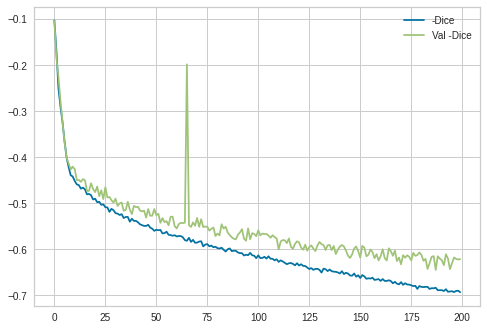

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 20s 405ms/step - loss: -0.1102 - iou: 0.0583 - dice_coef: 0.1101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6455 - val_loss: -0.1144 - val_iou: 0.0607 - val_dice_coef: 0.1144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5255


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 18s 396ms/step - loss: -0.2357 - iou: 0.1359 - dice_coef: 0.2372 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8517 - val_loss: -0.2551 - val_iou: 0.1464 - val_dice_coef: 0.2551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9411


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 18s 396ms/step - loss: -0.3110 - iou: 0.1851 - dice_coef: 0.3111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9183 - val_loss: -0.3001 - val_iou: 0.1779 - val_dice_coef: 0.3001 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9361


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 394ms/step - loss: -0.3608 - iou: 0.2218 - dice_coef: 0.3616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9368 - val_loss: -0.3283 - val_iou: 0.1975 - val_dice_coef: 0.3283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9527


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 18s 396ms/step - loss: -0.4112 - iou: 0.2602 - dice_coef: 0.4120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9526 - val_loss: -0.3814 - val_iou: 0.2363 - val_dice_coef: 0.3814 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9492


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 18s 394ms/step - loss: -0.4685 - iou: 0.3075 - dice_coef: 0.4691 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9617 - val_loss: -0.4812 - val_iou: 0.3176 - val_dice_coef: 0.4812 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9684


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 18s 398ms/step - loss: -0.5372 - iou: 0.3698 - dice_coef: 0.5378 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9686 - val_loss: -0.5134 - val_iou: 0.3494 - val_dice_coef: 0.5134 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9616


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5626 - iou: 0.3931 - dice_coef: 0.5622 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9698 - val_loss: -0.5815 - val_iou: 0.4122 - val_dice_coef: 0.5815 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9711


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5990 - iou: 0.4296 - dice_coef: 0.5987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9723 - val_loss: -0.5773 - val_iou: 0.4094 - val_dice_coef: 0.5773 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6156 - iou: 0.4483 - dice_coef: 0.6162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9733 - val_loss: -0.6023 - val_iou: 0.4370 - val_dice_coef: 0.6023 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6194 - iou: 0.4522 - dice_coef: 0.6199 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9741 - val_loss: -0.6163 - val_iou: 0.4473 - val_dice_coef: 0.6163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6381 - iou: 0.4713 - dice_coef: 0.6383 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.6171 - val_iou: 0.4505 - val_dice_coef: 0.6171 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6377 - iou: 0.4713 - dice_coef: 0.6380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.6181 - val_iou: 0.4527 - val_dice_coef: 0.6181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6412 - iou: 0.4761 - dice_coef: 0.6412 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9756 - val_loss: -0.6088 - val_iou: 0.4429 - val_dice_coef: 0.6088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6476 - iou: 0.4813 - dice_coef: 0.6473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9761 - val_loss: -0.6270 - val_iou: 0.4602 - val_dice_coef: 0.6270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6514 - iou: 0.4862 - dice_coef: 0.6516 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -0.6328 - val_iou: 0.4711 - val_dice_coef: 0.6328 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6570 - iou: 0.4930 - dice_coef: 0.6576 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9766 - val_loss: -0.6443 - val_iou: 0.4802 - val_dice_coef: 0.6443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6668 - iou: 0.5031 - dice_coef: 0.6668 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.6353 - val_iou: 0.4722 - val_dice_coef: 0.6353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6629 - iou: 0.5001 - dice_coef: 0.6631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -0.6295 - val_iou: 0.4719 - val_dice_coef: 0.6295 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6730 - iou: 0.5115 - dice_coef: 0.6731 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -0.6386 - val_iou: 0.4756 - val_dice_coef: 0.6386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6677 - iou: 0.5045 - dice_coef: 0.6680 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.6408 - val_iou: 0.4799 - val_dice_coef: 0.6408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6801 - iou: 0.5190 - dice_coef: 0.6800 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.6663 - val_iou: 0.5046 - val_dice_coef: 0.6663 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6840 - iou: 0.5229 - dice_coef: 0.6838 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6735 - val_iou: 0.5107 - val_dice_coef: 0.6735 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 403ms/step - loss: -0.6869 - iou: 0.5268 - dice_coef: 0.6863 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6633 - val_iou: 0.5025 - val_dice_coef: 0.6633 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 394ms/step - loss: -0.6862 - iou: 0.5260 - dice_coef: 0.6858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6748 - val_iou: 0.5130 - val_dice_coef: 0.6748 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 18s 398ms/step - loss: -0.6977 - iou: 0.5393 - dice_coef: 0.6977 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.6518 - val_iou: 0.4990 - val_dice_coef: 0.6518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7045 - iou: 0.5409 - dice_coef: 0.6995 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.6832 - val_iou: 0.5243 - val_dice_coef: 0.6832 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7038 - iou: 0.5462 - dice_coef: 0.7034 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.6581 - val_iou: 0.5051 - val_dice_coef: 0.6581 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7056 - iou: 0.5475 - dice_coef: 0.7054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.6885 - val_iou: 0.5290 - val_dice_coef: 0.6885 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7011 - iou: 0.5434 - dice_coef: 0.7009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.6889 - val_iou: 0.5272 - val_dice_coef: 0.6889 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7101 - iou: 0.5551 - dice_coef: 0.7104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.6570 - val_iou: 0.5024 - val_dice_coef: 0.6570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7178 - iou: 0.5633 - dice_coef: 0.7181 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.6753 - val_iou: 0.5225 - val_dice_coef: 0.6753 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7180 - iou: 0.5623 - dice_coef: 0.7170 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.6989 - val_iou: 0.5401 - val_dice_coef: 0.6989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7223 - iou: 0.5692 - dice_coef: 0.7222 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6901 - val_iou: 0.5373 - val_dice_coef: 0.6901 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7257 - iou: 0.5722 - dice_coef: 0.7252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.6872 - val_iou: 0.5356 - val_dice_coef: 0.6872 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7287 - iou: 0.5765 - dice_coef: 0.7289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7099 - val_iou: 0.5532 - val_dice_coef: 0.7099 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7295 - iou: 0.5780 - dice_coef: 0.7292 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.6841 - val_iou: 0.5333 - val_dice_coef: 0.6841 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7254 - iou: 0.5737 - dice_coef: 0.7250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.6977 - val_iou: 0.5437 - val_dice_coef: 0.6977 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 18s 390ms/step - loss: -0.7337 - iou: 0.5832 - dice_coef: 0.7338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.6961 - val_iou: 0.5459 - val_dice_coef: 0.6961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7274 - iou: 0.5765 - dice_coef: 0.7272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.6826 - val_iou: 0.5352 - val_dice_coef: 0.6826 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7383 - iou: 0.5892 - dice_coef: 0.7384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6984 - val_iou: 0.5469 - val_dice_coef: 0.6984 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7413 - iou: 0.5928 - dice_coef: 0.7412 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6925 - val_iou: 0.5456 - val_dice_coef: 0.6925 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7375 - iou: 0.5887 - dice_coef: 0.7373 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.7247 - val_iou: 0.5724 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7434 - iou: 0.5938 - dice_coef: 0.7427 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.7231 - val_iou: 0.5707 - val_dice_coef: 0.7231 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7416 - iou: 0.5956 - dice_coef: 0.7419 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.7046 - val_iou: 0.5520 - val_dice_coef: 0.7046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7480 - iou: 0.5991 - dice_coef: 0.7470 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.7125 - val_iou: 0.5652 - val_dice_coef: 0.7125 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7443 - iou: 0.5986 - dice_coef: 0.7453 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.7203 - val_iou: 0.5688 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7467 - iou: 0.6002 - dice_coef: 0.7469 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7087 - val_iou: 0.5642 - val_dice_coef: 0.7087 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7538 - iou: 0.6101 - dice_coef: 0.7547 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7018 - val_iou: 0.5575 - val_dice_coef: 0.7018 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7523 - iou: 0.6087 - dice_coef: 0.7530 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7029 - val_iou: 0.5561 - val_dice_coef: 0.7029 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7567 - iou: 0.6135 - dice_coef: 0.7573 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6939 - val_iou: 0.5497 - val_dice_coef: 0.6939 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7548 - iou: 0.6101 - dice_coef: 0.7548 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.7039 - val_iou: 0.5661 - val_dice_coef: 0.7039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 18s 391ms/step - loss: -0.7553 - iou: 0.6114 - dice_coef: 0.7556 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.7427 - val_iou: 0.5935 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7541 - iou: 0.6099 - dice_coef: 0.7543 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7291 - val_iou: 0.5794 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7625 - iou: 0.6227 - dice_coef: 0.7630 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7281 - val_iou: 0.5844 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7618 - iou: 0.6213 - dice_coef: 0.7618 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7409 - val_iou: 0.5915 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7583 - iou: 0.6177 - dice_coef: 0.7590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7194 - val_iou: 0.5760 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7581 - iou: 0.6144 - dice_coef: 0.7577 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7479 - val_iou: 0.6004 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7673 - iou: 0.6258 - dice_coef: 0.7673 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7154 - val_iou: 0.5699 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7557 - iou: 0.6132 - dice_coef: 0.7560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.7211 - val_iou: 0.5769 - val_dice_coef: 0.7211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7690 - iou: 0.6295 - dice_coef: 0.7695 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7519 - val_iou: 0.6038 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7648 - iou: 0.6257 - dice_coef: 0.7650 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7303 - val_iou: 0.5840 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7678 - iou: 0.6268 - dice_coef: 0.7676 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7329 - val_iou: 0.5846 - val_dice_coef: 0.7329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7691 - iou: 0.6302 - dice_coef: 0.7694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7343 - val_iou: 0.5893 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7674 - iou: 0.6288 - dice_coef: 0.7677 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7471 - val_iou: 0.6010 - val_dice_coef: 0.7471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7710 - iou: 0.6317 - dice_coef: 0.7711 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7213 - val_iou: 0.5783 - val_dice_coef: 0.7213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7714 - iou: 0.6339 - dice_coef: 0.7720 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7562 - val_iou: 0.6098 - val_dice_coef: 0.7562 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7752 - iou: 0.6352 - dice_coef: 0.7743 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7221 - val_iou: 0.5803 - val_dice_coef: 0.7221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7690 - iou: 0.6313 - dice_coef: 0.7697 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7159 - val_iou: 0.5757 - val_dice_coef: 0.7159 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7742 - iou: 0.6350 - dice_coef: 0.7745 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7259 - val_iou: 0.5815 - val_dice_coef: 0.7259 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7692 - iou: 0.6326 - dice_coef: 0.7694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7140 - val_iou: 0.5771 - val_dice_coef: 0.7140 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7715 - iou: 0.6341 - dice_coef: 0.7727 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7475 - val_iou: 0.6010 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7741 - iou: 0.6375 - dice_coef: 0.7741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7286 - val_iou: 0.5855 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7834 - iou: 0.6405 - dice_coef: 0.7772 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7101 - val_iou: 0.5665 - val_dice_coef: 0.7101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7744 - iou: 0.6356 - dice_coef: 0.7741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7228 - val_iou: 0.5841 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7774 - iou: 0.6425 - dice_coef: 0.7777 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7523 - val_iou: 0.6090 - val_dice_coef: 0.7523 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7721 - iou: 0.6347 - dice_coef: 0.7721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7427 - val_iou: 0.5978 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7796 - iou: 0.6441 - dice_coef: 0.7798 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7518 - val_iou: 0.6061 - val_dice_coef: 0.7518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7792 - iou: 0.6443 - dice_coef: 0.7799 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7272 - val_iou: 0.5852 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7814 - iou: 0.6481 - dice_coef: 0.7825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7297 - val_iou: 0.5901 - val_dice_coef: 0.7297 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7796 - iou: 0.6449 - dice_coef: 0.7799 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7146 - val_iou: 0.5710 - val_dice_coef: 0.7146 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7824 - iou: 0.6474 - dice_coef: 0.7818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7543 - val_iou: 0.6112 - val_dice_coef: 0.7543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7790 - iou: 0.6427 - dice_coef: 0.7788 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7536 - val_iou: 0.6103 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 390ms/step - loss: -0.7854 - iou: 0.6531 - dice_coef: 0.7859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7407 - val_iou: 0.5970 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7835 - iou: 0.6502 - dice_coef: 0.7840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7525 - val_iou: 0.6094 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7878 - iou: 0.6546 - dice_coef: 0.7878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7390 - val_iou: 0.6027 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7838 - iou: 0.6488 - dice_coef: 0.7841 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7424 - val_iou: 0.6016 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 413ms/step - loss: -0.7802 - iou: 0.6459 - dice_coef: 0.7807 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7479 - val_iou: 0.6057 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7893 - iou: 0.6561 - dice_coef: 0.7899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7541 - val_iou: 0.6111 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7843 - iou: 0.6511 - dice_coef: 0.7847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7426 - val_iou: 0.5967 - val_dice_coef: 0.7426 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7857 - iou: 0.6518 - dice_coef: 0.7850 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7261 - val_iou: 0.5852 - val_dice_coef: 0.7261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7892 - iou: 0.6557 - dice_coef: 0.7889 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7311 - val_iou: 0.5939 - val_dice_coef: 0.7311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7848 - iou: 0.6508 - dice_coef: 0.7847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7504 - val_iou: 0.6105 - val_dice_coef: 0.7504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7872 - iou: 0.6558 - dice_coef: 0.7874 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7466 - val_iou: 0.6024 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7930 - iou: 0.6609 - dice_coef: 0.7930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7540 - val_iou: 0.6091 - val_dice_coef: 0.7540 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7860 - iou: 0.6546 - dice_coef: 0.7864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7568 - val_iou: 0.6138 - val_dice_coef: 0.7568 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7890 - iou: 0.6568 - dice_coef: 0.7894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7287 - val_iou: 0.5912 - val_dice_coef: 0.7287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7947 - iou: 0.6641 - dice_coef: 0.7944 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7341 - val_iou: 0.5971 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7928 - iou: 0.6613 - dice_coef: 0.7930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7308 - val_iou: 0.5895 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7904 - iou: 0.6580 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7367 - val_iou: 0.5994 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7917 - iou: 0.6623 - dice_coef: 0.7921 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7198 - val_iou: 0.5830 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7911 - iou: 0.6610 - dice_coef: 0.7915 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7289 - val_iou: 0.5892 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7915 - iou: 0.6598 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7565 - val_iou: 0.6126 - val_dice_coef: 0.7565 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7928 - iou: 0.6613 - dice_coef: 0.7924 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7606 - val_iou: 0.6200 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7971 - iou: 0.6680 - dice_coef: 0.7973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7502 - val_iou: 0.6107 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7954 - iou: 0.6664 - dice_coef: 0.7958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7542 - val_iou: 0.6114 - val_dice_coef: 0.7542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7920 - iou: 0.6614 - dice_coef: 0.7927 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7416 - val_iou: 0.6033 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7987 - iou: 0.6692 - dice_coef: 0.7987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7518 - val_iou: 0.6112 - val_dice_coef: 0.7518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7966 - iou: 0.6668 - dice_coef: 0.7966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7304 - val_iou: 0.5915 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7905 - iou: 0.6602 - dice_coef: 0.7912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7513 - val_iou: 0.6089 - val_dice_coef: 0.7513 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7965 - iou: 0.6670 - dice_coef: 0.7967 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7333 - val_iou: 0.5959 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8010 - iou: 0.6732 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7555 - val_iou: 0.6142 - val_dice_coef: 0.7555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7941 - iou: 0.6635 - dice_coef: 0.7937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7317 - val_iou: 0.5973 - val_dice_coef: 0.7317 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7984 - iou: 0.6710 - dice_coef: 0.7987 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7383 - val_iou: 0.6013 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7968 - iou: 0.6678 - dice_coef: 0.7976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7443 - val_iou: 0.6084 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7968 - iou: 0.6666 - dice_coef: 0.7963 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7490 - val_iou: 0.6039 - val_dice_coef: 0.7490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7974 - iou: 0.6691 - dice_coef: 0.7976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7449 - val_iou: 0.6032 - val_dice_coef: 0.7449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8009 - iou: 0.6722 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7229 - val_iou: 0.5912 - val_dice_coef: 0.7229 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7977 - iou: 0.6679 - dice_coef: 0.7978 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7404 - val_iou: 0.6017 - val_dice_coef: 0.7404 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7974 - iou: 0.6692 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7438 - val_iou: 0.6052 - val_dice_coef: 0.7438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8073 - iou: 0.6734 - dice_coef: 0.8005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7497 - val_iou: 0.6097 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8024 - iou: 0.6759 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7556 - val_iou: 0.6127 - val_dice_coef: 0.7556 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7997 - iou: 0.6730 - dice_coef: 0.7999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7372 - val_iou: 0.5983 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8034 - iou: 0.6770 - dice_coef: 0.8039 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7490 - val_iou: 0.6169 - val_dice_coef: 0.7490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7997 - iou: 0.6728 - dice_coef: 0.8001 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7533 - val_iou: 0.6125 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8049 - iou: 0.6783 - dice_coef: 0.8049 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7285 - val_iou: 0.5957 - val_dice_coef: 0.7285 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8021 - iou: 0.6764 - dice_coef: 0.8025 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7358 - val_iou: 0.6041 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8030 - iou: 0.6775 - dice_coef: 0.8036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7634 - val_iou: 0.6228 - val_dice_coef: 0.7634 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8067 - iou: 0.6816 - dice_coef: 0.8064 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7442 - val_iou: 0.6059 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8005 - iou: 0.6714 - dice_coef: 0.8004 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7513 - val_iou: 0.6104 - val_dice_coef: 0.7513 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8020 - iou: 0.6758 - dice_coef: 0.8022 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7416 - val_iou: 0.6013 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8041 - iou: 0.6770 - dice_coef: 0.8033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7621 - val_iou: 0.6197 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8058 - iou: 0.6817 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7299 - val_iou: 0.5969 - val_dice_coef: 0.7299 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8018 - iou: 0.6763 - dice_coef: 0.8023 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7356 - val_iou: 0.5956 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8097 - iou: 0.6853 - dice_coef: 0.8095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7443 - val_iou: 0.6086 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8026 - iou: 0.6782 - dice_coef: 0.8029 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7254 - val_iou: 0.5891 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8065 - iou: 0.6799 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7478 - val_iou: 0.6065 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8069 - iou: 0.6820 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7595 - val_iou: 0.6191 - val_dice_coef: 0.7595 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8090 - iou: 0.6845 - dice_coef: 0.8093 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7606 - val_iou: 0.6189 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8060 - iou: 0.6813 - dice_coef: 0.8062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7580 - val_iou: 0.6186 - val_dice_coef: 0.7580 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8065 - iou: 0.6821 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7469 - val_iou: 0.6060 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8095 - iou: 0.6851 - dice_coef: 0.8092 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7404 - val_iou: 0.6047 - val_dice_coef: 0.7404 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8080 - iou: 0.6846 - dice_coef: 0.8082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7666 - val_iou: 0.6265 - val_dice_coef: 0.7666 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8045 - iou: 0.6768 - dice_coef: 0.8048 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7426 - val_iou: 0.6029 - val_dice_coef: 0.7426 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8084 - iou: 0.6835 - dice_coef: 0.8081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7533 - val_iou: 0.6122 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8142 - iou: 0.6918 - dice_coef: 0.8145 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7605 - val_iou: 0.6184 - val_dice_coef: 0.7605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8062 - iou: 0.6803 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7435 - val_iou: 0.6051 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8026 - iou: 0.6769 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7736 - val_iou: 0.6329 - val_dice_coef: 0.7736 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8079 - iou: 0.6849 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7373 - val_iou: 0.5966 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8095 - iou: 0.6857 - dice_coef: 0.8094 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7473 - val_iou: 0.6130 - val_dice_coef: 0.7473 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8087 - iou: 0.6852 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7520 - val_iou: 0.6111 - val_dice_coef: 0.7520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 18s 409ms/step - loss: -0.8082 - iou: 0.6851 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7705 - val_iou: 0.6313 - val_dice_coef: 0.7705 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9852


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8120 - iou: 0.6903 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7619 - val_iou: 0.6212 - val_dice_coef: 0.7619 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8140 - iou: 0.6910 - dice_coef: 0.8140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7623 - val_iou: 0.6234 - val_dice_coef: 0.7623 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8147 - iou: 0.6929 - dice_coef: 0.8150 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7425 - val_iou: 0.6051 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8093 - iou: 0.6862 - dice_coef: 0.8098 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7677 - val_iou: 0.6265 - val_dice_coef: 0.7677 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9851


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8120 - iou: 0.6904 - dice_coef: 0.8125 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7439 - val_iou: 0.6057 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8141 - iou: 0.6911 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7355 - val_iou: 0.6001 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8121 - iou: 0.6892 - dice_coef: 0.8125 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7419 - val_iou: 0.6090 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8137 - iou: 0.6909 - dice_coef: 0.8135 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7384 - val_iou: 0.6020 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8096 - iou: 0.6863 - dice_coef: 0.8098 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7400 - val_iou: 0.5996 - val_dice_coef: 0.7400 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8137 - iou: 0.6920 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7475 - val_iou: 0.6084 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8093 - iou: 0.6858 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7432 - val_iou: 0.6047 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8077 - iou: 0.6829 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7629 - val_iou: 0.6227 - val_dice_coef: 0.7629 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8092 - iou: 0.6865 - dice_coef: 0.8097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7421 - val_iou: 0.6028 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8135 - iou: 0.6926 - dice_coef: 0.8136 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7542 - val_iou: 0.6150 - val_dice_coef: 0.7542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8150 - iou: 0.6933 - dice_coef: 0.8150 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7383 - val_iou: 0.6050 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8231 - iou: 0.6956 - dice_coef: 0.8164 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7468 - val_iou: 0.6049 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8113 - iou: 0.6911 - dice_coef: 0.8120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7435 - val_iou: 0.6055 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8160 - iou: 0.6958 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7323 - val_iou: 0.5956 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8104 - iou: 0.6883 - dice_coef: 0.8108 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7286 - val_iou: 0.5905 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8145 - iou: 0.6930 - dice_coef: 0.8149 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7348 - val_iou: 0.6005 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8157 - iou: 0.6939 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7504 - val_iou: 0.6103 - val_dice_coef: 0.7504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8201 - iou: 0.7015 - dice_coef: 0.8206 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7649 - val_iou: 0.6232 - val_dice_coef: 0.7649 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8161 - iou: 0.6945 - dice_coef: 0.8161 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7336 - val_iou: 0.5994 - val_dice_coef: 0.7336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8159 - iou: 0.6959 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7592 - val_iou: 0.6221 - val_dice_coef: 0.7592 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8190 - iou: 0.6972 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7544 - val_iou: 0.6150 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8197 - iou: 0.7006 - dice_coef: 0.8191 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7446 - val_iou: 0.6063 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8157 - iou: 0.6950 - dice_coef: 0.8157 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7244 - val_iou: 0.5887 - val_dice_coef: 0.7244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8170 - iou: 0.6945 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7443 - val_iou: 0.6064 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8211 - iou: 0.7023 - dice_coef: 0.8210 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7412 - val_iou: 0.6009 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8170 - iou: 0.6971 - dice_coef: 0.8176 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7353 - val_iou: 0.5990 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8196 - iou: 0.7012 - dice_coef: 0.8203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7280 - val_iou: 0.5937 - val_dice_coef: 0.7280 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8222 - iou: 0.7027 - dice_coef: 0.8225 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7490 - val_iou: 0.6141 - val_dice_coef: 0.7490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8215 - iou: 0.7023 - dice_coef: 0.8212 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7304 - val_iou: 0.5952 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8171 - iou: 0.6968 - dice_coef: 0.8177 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7574 - val_iou: 0.6155 - val_dice_coef: 0.7574 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8208 - iou: 0.7045 - dice_coef: 0.8213 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7344 - val_iou: 0.5980 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8199 - iou: 0.7016 - dice_coef: 0.8202 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7579 - val_iou: 0.6159 - val_dice_coef: 0.7579 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8228 - iou: 0.7054 - dice_coef: 0.8228 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7511 - val_iou: 0.6141 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8201 - iou: 0.6997 - dice_coef: 0.8190 - sensitivity: 0.9984 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7354 - val_iou: 0.5997 - val_dice_coef: 0.7354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8216 - iou: 0.7019 - dice_coef: 0.8219 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7642 - val_iou: 0.6235 - val_dice_coef: 0.7642 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8197 - iou: 0.7009 - dice_coef: 0.8197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7492 - val_iou: 0.6081 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8173 - iou: 0.6946 - dice_coef: 0.8167 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7386 - val_iou: 0.6031 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8215 - iou: 0.7038 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7467 - val_iou: 0.6137 - val_dice_coef: 0.7467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8179 - iou: 0.6977 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7705 - val_iou: 0.6285 - val_dice_coef: 0.7705 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8228 - iou: 0.7055 - dice_coef: 0.8227 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7402 - val_iou: 0.6057 - val_dice_coef: 0.7402 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8162 - iou: 0.6956 - dice_coef: 0.8168 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7659 - val_iou: 0.6273 - val_dice_coef: 0.7659 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8234 - iou: 0.7064 - dice_coef: 0.8235 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7749 - val_iou: 0.6355 - val_dice_coef: 0.7749 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9851


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8249 - iou: 0.7081 - dice_coef: 0.8250 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7308 - val_iou: 0.5964 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8176 - iou: 0.6988 - dice_coef: 0.8181 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7487 - val_iou: 0.6097 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


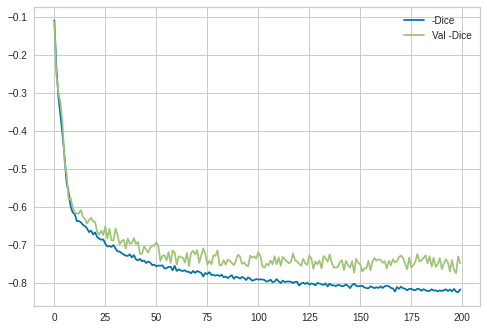

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 19s 403ms/step - loss: -0.1074 - iou: 0.0567 - dice_coef: 0.1074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9146 - val_loss: -0.1048 - val_iou: 0.0553 - val_dice_coef: 0.1048 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.7922


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 18s 410ms/step - loss: -0.1936 - iou: 0.1080 - dice_coef: 0.1940 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9194 - val_loss: -0.1916 - val_iou: 0.1060 - val_dice_coef: 0.1916 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9067


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 18s 402ms/step - loss: -0.2674 - iou: 0.1547 - dice_coef: 0.2672 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9458 - val_loss: -0.2181 - val_iou: 0.1225 - val_dice_coef: 0.2181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9119


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 399ms/step - loss: -0.3063 - iou: 0.1816 - dice_coef: 0.3067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9517 - val_loss: -0.2961 - val_iou: 0.1746 - val_dice_coef: 0.2961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9654


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 18s 407ms/step - loss: -0.3605 - iou: 0.2215 - dice_coef: 0.3616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9675 - val_loss: -0.3232 - val_iou: 0.1935 - val_dice_coef: 0.3232 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9551


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 18s 396ms/step - loss: -0.3723 - iou: 0.2297 - dice_coef: 0.3727 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9656 - val_loss: -0.3806 - val_iou: 0.2359 - val_dice_coef: 0.3806 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9715


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 18s 397ms/step - loss: -0.4087 - iou: 0.2577 - dice_coef: 0.4088 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9713 - val_loss: -0.3670 - val_iou: 0.2283 - val_dice_coef: 0.3670 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 396ms/step - loss: -0.4219 - iou: 0.2680 - dice_coef: 0.4215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9725 - val_loss: -0.4032 - val_iou: 0.2557 - val_dice_coef: 0.4032 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9718


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 18s 393ms/step - loss: -0.4318 - iou: 0.2769 - dice_coef: 0.4321 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9726 - val_loss: -0.4034 - val_iou: 0.2548 - val_dice_coef: 0.4034 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9650


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 18s 395ms/step - loss: -0.4402 - iou: 0.2827 - dice_coef: 0.4394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9723 - val_loss: -0.4471 - val_iou: 0.2883 - val_dice_coef: 0.4471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 18s 402ms/step - loss: -0.4539 - iou: 0.2954 - dice_coef: 0.4545 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.4372 - val_iou: 0.2815 - val_dice_coef: 0.4372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 396ms/step - loss: -0.4628 - iou: 0.3018 - dice_coef: 0.4625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9755 - val_loss: -0.4373 - val_iou: 0.2825 - val_dice_coef: 0.4373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 18s 399ms/step - loss: -0.4655 - iou: 0.3043 - dice_coef: 0.4654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.4497 - val_iou: 0.2918 - val_dice_coef: 0.4497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 402ms/step - loss: -0.4729 - iou: 0.3101 - dice_coef: 0.4721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9760 - val_loss: -0.4630 - val_iou: 0.3024 - val_dice_coef: 0.4630 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 397ms/step - loss: -0.4786 - iou: 0.3156 - dice_coef: 0.4786 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9763 - val_loss: -0.4498 - val_iou: 0.2942 - val_dice_coef: 0.4498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 18s 402ms/step - loss: -0.4872 - iou: 0.3203 - dice_coef: 0.4840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9770 - val_loss: -0.4718 - val_iou: 0.3108 - val_dice_coef: 0.4718 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 18s 392ms/step - loss: -0.5090 - iou: 0.3442 - dice_coef: 0.5099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -0.6074 - val_iou: 0.4447 - val_dice_coef: 0.6074 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 18s 404ms/step - loss: -0.6678 - iou: 0.5041 - dice_coef: 0.6675 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.6274 - val_iou: 0.4675 - val_dice_coef: 0.6274 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 18s 409ms/step - loss: -0.6689 - iou: 0.5047 - dice_coef: 0.6687 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -0.6405 - val_iou: 0.4839 - val_dice_coef: 0.6405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6814 - iou: 0.5213 - dice_coef: 0.6818 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9783 - val_loss: -0.6739 - val_iou: 0.5128 - val_dice_coef: 0.6739 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 18s 399ms/step - loss: -0.6908 - iou: 0.5322 - dice_coef: 0.6913 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -0.6620 - val_iou: 0.5040 - val_dice_coef: 0.6620 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7034 - iou: 0.5474 - dice_coef: 0.7041 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.6469 - val_iou: 0.4847 - val_dice_coef: 0.6469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6995 - iou: 0.5419 - dice_coef: 0.7001 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.6945 - val_iou: 0.5347 - val_dice_coef: 0.6945 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7076 - iou: 0.5521 - dice_coef: 0.7083 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.6732 - val_iou: 0.5145 - val_dice_coef: 0.6732 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7134 - iou: 0.5586 - dice_coef: 0.7139 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.6757 - val_iou: 0.5176 - val_dice_coef: 0.6757 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7160 - iou: 0.5630 - dice_coef: 0.7164 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.6798 - val_iou: 0.5274 - val_dice_coef: 0.6798 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7230 - iou: 0.5699 - dice_coef: 0.7236 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6936 - val_iou: 0.5348 - val_dice_coef: 0.6936 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7208 - iou: 0.5672 - dice_coef: 0.7205 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.6800 - val_iou: 0.5301 - val_dice_coef: 0.6800 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7265 - iou: 0.5743 - dice_coef: 0.7257 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.7034 - val_iou: 0.5495 - val_dice_coef: 0.7034 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7331 - iou: 0.5820 - dice_coef: 0.7336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.7093 - val_iou: 0.5522 - val_dice_coef: 0.7093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7381 - iou: 0.5893 - dice_coef: 0.7381 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.6859 - val_iou: 0.5375 - val_dice_coef: 0.6859 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7305 - iou: 0.5801 - dice_coef: 0.7309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.7111 - val_iou: 0.5564 - val_dice_coef: 0.7111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 19s 411ms/step - loss: -0.7440 - iou: 0.5959 - dice_coef: 0.7435 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7094 - val_iou: 0.5585 - val_dice_coef: 0.7094 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7429 - iou: 0.5961 - dice_coef: 0.7435 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.6961 - val_iou: 0.5475 - val_dice_coef: 0.6961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7451 - iou: 0.5972 - dice_coef: 0.7446 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7174 - val_iou: 0.5646 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7449 - iou: 0.5993 - dice_coef: 0.7457 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7000 - val_iou: 0.5572 - val_dice_coef: 0.7000 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7464 - iou: 0.5997 - dice_coef: 0.7460 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7214 - val_iou: 0.5720 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7529 - iou: 0.6082 - dice_coef: 0.7530 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7053 - val_iou: 0.5555 - val_dice_coef: 0.7053 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7515 - iou: 0.6064 - dice_coef: 0.7518 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.7175 - val_iou: 0.5674 - val_dice_coef: 0.7175 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7524 - iou: 0.6061 - dice_coef: 0.7509 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.7127 - val_iou: 0.5647 - val_dice_coef: 0.7127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7578 - iou: 0.6134 - dice_coef: 0.7583 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.6996 - val_iou: 0.5570 - val_dice_coef: 0.6996 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7624 - iou: 0.6226 - dice_coef: 0.7631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7070 - val_iou: 0.5641 - val_dice_coef: 0.7070 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7571 - iou: 0.6147 - dice_coef: 0.7577 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.7047 - val_iou: 0.5603 - val_dice_coef: 0.7047 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7637 - iou: 0.6221 - dice_coef: 0.7635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7217 - val_iou: 0.5765 - val_dice_coef: 0.7217 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7583 - iou: 0.6162 - dice_coef: 0.7588 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.7460 - val_iou: 0.5994 - val_dice_coef: 0.7460 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7690 - iou: 0.6295 - dice_coef: 0.7694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7060 - val_iou: 0.5599 - val_dice_coef: 0.7060 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7650 - iou: 0.6227 - dice_coef: 0.7646 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.7168 - val_iou: 0.5729 - val_dice_coef: 0.7168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 411ms/step - loss: -0.7699 - iou: 0.6311 - dice_coef: 0.7705 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7183 - val_iou: 0.5749 - val_dice_coef: 0.7183 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7671 - iou: 0.6273 - dice_coef: 0.7667 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7214 - val_iou: 0.5793 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7731 - iou: 0.6338 - dice_coef: 0.7726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7143 - val_iou: 0.5721 - val_dice_coef: 0.7143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7688 - iou: 0.6291 - dice_coef: 0.7689 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7153 - val_iou: 0.5732 - val_dice_coef: 0.7153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7716 - iou: 0.6317 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7157 - val_iou: 0.5694 - val_dice_coef: 0.7157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7741 - iou: 0.6371 - dice_coef: 0.7747 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7507 - val_iou: 0.6043 - val_dice_coef: 0.7507 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7732 - iou: 0.6355 - dice_coef: 0.7736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7377 - val_iou: 0.5931 - val_dice_coef: 0.7377 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7720 - iou: 0.6333 - dice_coef: 0.7721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7372 - val_iou: 0.5894 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7735 - iou: 0.6362 - dice_coef: 0.7730 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7458 - val_iou: 0.5991 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7797 - iou: 0.6443 - dice_coef: 0.7795 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7169 - val_iou: 0.5775 - val_dice_coef: 0.7169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7765 - iou: 0.6394 - dice_coef: 0.7762 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7354 - val_iou: 0.5922 - val_dice_coef: 0.7354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7736 - iou: 0.6379 - dice_coef: 0.7737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7301 - val_iou: 0.5880 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7804 - iou: 0.6445 - dice_coef: 0.7801 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7244 - val_iou: 0.5864 - val_dice_coef: 0.7244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7824 - iou: 0.6486 - dice_coef: 0.7828 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7286 - val_iou: 0.5890 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7794 - iou: 0.6449 - dice_coef: 0.7794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7218 - val_iou: 0.5796 - val_dice_coef: 0.7218 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7872 - iou: 0.6459 - dice_coef: 0.7817 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7293 - val_iou: 0.5883 - val_dice_coef: 0.7293 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7824 - iou: 0.6499 - dice_coef: 0.7830 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7404 - val_iou: 0.5951 - val_dice_coef: 0.7404 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7885 - iou: 0.6549 - dice_coef: 0.7890 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7224 - val_iou: 0.5806 - val_dice_coef: 0.7224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7831 - iou: 0.6486 - dice_coef: 0.7830 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7290 - val_iou: 0.5885 - val_dice_coef: 0.7290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7888 - iou: 0.6557 - dice_coef: 0.7885 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7434 - val_iou: 0.6012 - val_dice_coef: 0.7434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7863 - iou: 0.6535 - dice_coef: 0.7868 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7235 - val_iou: 0.5807 - val_dice_coef: 0.7235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7836 - iou: 0.6482 - dice_coef: 0.7833 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7479 - val_iou: 0.6087 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7874 - iou: 0.6546 - dice_coef: 0.7875 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7430 - val_iou: 0.5993 - val_dice_coef: 0.7430 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 18s 392ms/step - loss: -0.7859 - iou: 0.6526 - dice_coef: 0.7860 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7373 - val_iou: 0.5982 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7882 - iou: 0.6545 - dice_coef: 0.7882 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7055 - val_iou: 0.5664 - val_dice_coef: 0.7055 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7854 - iou: 0.6535 - dice_coef: 0.7858 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7375 - val_iou: 0.5965 - val_dice_coef: 0.7375 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7873 - iou: 0.6558 - dice_coef: 0.7878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7415 - val_iou: 0.6018 - val_dice_coef: 0.7415 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7904 - iou: 0.6580 - dice_coef: 0.7897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7229 - val_iou: 0.5802 - val_dice_coef: 0.7229 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7876 - iou: 0.6547 - dice_coef: 0.7880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7368 - val_iou: 0.5927 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7894 - iou: 0.6569 - dice_coef: 0.7889 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7351 - val_iou: 0.5954 - val_dice_coef: 0.7351 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 18s 406ms/step - loss: -0.7858 - iou: 0.6546 - dice_coef: 0.7863 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7595 - val_iou: 0.6165 - val_dice_coef: 0.7595 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7909 - iou: 0.6601 - dice_coef: 0.7909 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7288 - val_iou: 0.5932 - val_dice_coef: 0.7288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7920 - iou: 0.6610 - dice_coef: 0.7924 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7307 - val_iou: 0.5913 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7962 - iou: 0.6671 - dice_coef: 0.7967 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7323 - val_iou: 0.5972 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7906 - iou: 0.6591 - dice_coef: 0.7909 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7493 - val_iou: 0.6045 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7914 - iou: 0.6600 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7217 - val_iou: 0.5850 - val_dice_coef: 0.7217 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7958 - iou: 0.6649 - dice_coef: 0.7953 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7352 - val_iou: 0.5985 - val_dice_coef: 0.7352 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7962 - iou: 0.6655 - dice_coef: 0.7959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7468 - val_iou: 0.6103 - val_dice_coef: 0.7468 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7971 - iou: 0.6692 - dice_coef: 0.7975 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7343 - val_iou: 0.5960 - val_dice_coef: 0.7343 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 18s 410ms/step - loss: -0.7952 - iou: 0.6666 - dice_coef: 0.7955 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7554 - val_iou: 0.6115 - val_dice_coef: 0.7554 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7980 - iou: 0.6676 - dice_coef: 0.7970 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7347 - val_iou: 0.5983 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 406ms/step - loss: -0.7952 - iou: 0.6658 - dice_coef: 0.7957 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7532 - val_iou: 0.6109 - val_dice_coef: 0.7532 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8009 - iou: 0.6737 - dice_coef: 0.8009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7357 - val_iou: 0.5982 - val_dice_coef: 0.7357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7972 - iou: 0.6674 - dice_coef: 0.7967 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7390 - val_iou: 0.5984 - val_dice_coef: 0.7390 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7917 - iou: 0.6621 - dice_coef: 0.7919 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7470 - val_iou: 0.6071 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7985 - iou: 0.6710 - dice_coef: 0.7990 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7292 - val_iou: 0.5926 - val_dice_coef: 0.7292 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7924 - iou: 0.6619 - dice_coef: 0.7919 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7150 - val_iou: 0.5782 - val_dice_coef: 0.7150 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7983 - iou: 0.6693 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7370 - val_iou: 0.6006 - val_dice_coef: 0.7370 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8028 - iou: 0.6754 - dice_coef: 0.8032 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7551 - val_iou: 0.6112 - val_dice_coef: 0.7551 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8017 - iou: 0.6747 - dice_coef: 0.8024 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7330 - val_iou: 0.5965 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8019 - iou: 0.6745 - dice_coef: 0.8022 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7259 - val_iou: 0.5886 - val_dice_coef: 0.7259 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8027 - iou: 0.6767 - dice_coef: 0.8029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7617 - val_iou: 0.6191 - val_dice_coef: 0.7617 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8034 - iou: 0.6759 - dice_coef: 0.8024 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7345 - val_iou: 0.6018 - val_dice_coef: 0.7345 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7983 - iou: 0.6698 - dice_coef: 0.7986 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7578 - val_iou: 0.6176 - val_dice_coef: 0.7578 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8008 - iou: 0.6726 - dice_coef: 0.8002 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7484 - val_iou: 0.6054 - val_dice_coef: 0.7484 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8031 - iou: 0.6777 - dice_coef: 0.8038 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7435 - val_iou: 0.6061 - val_dice_coef: 0.7435 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8048 - iou: 0.6787 - dice_coef: 0.8049 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7491 - val_iou: 0.6081 - val_dice_coef: 0.7491 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8054 - iou: 0.6794 - dice_coef: 0.8049 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7381 - val_iou: 0.5980 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8038 - iou: 0.6778 - dice_coef: 0.8042 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7538 - val_iou: 0.6126 - val_dice_coef: 0.7538 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8038 - iou: 0.6785 - dice_coef: 0.8041 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7352 - val_iou: 0.6007 - val_dice_coef: 0.7352 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8057 - iou: 0.6783 - dice_coef: 0.8057 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7403 - val_iou: 0.5955 - val_dice_coef: 0.7403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 412ms/step - loss: -0.8060 - iou: 0.6809 - dice_coef: 0.8060 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7372 - val_iou: 0.6047 - val_dice_coef: 0.7372 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8126 - iou: 0.6806 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7502 - val_iou: 0.6088 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8062 - iou: 0.6818 - dice_coef: 0.8067 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7301 - val_iou: 0.5915 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8061 - iou: 0.6795 - dice_coef: 0.8057 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7312 - val_iou: 0.5923 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8059 - iou: 0.6810 - dice_coef: 0.8062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7421 - val_iou: 0.6014 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8087 - iou: 0.6821 - dice_coef: 0.8080 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7319 - val_iou: 0.5957 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8046 - iou: 0.6806 - dice_coef: 0.8048 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7354 - val_iou: 0.5964 - val_dice_coef: 0.7354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8071 - iou: 0.6813 - dice_coef: 0.8072 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7448 - val_iou: 0.6064 - val_dice_coef: 0.7448 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8115 - iou: 0.6875 - dice_coef: 0.8108 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7428 - val_iou: 0.6087 - val_dice_coef: 0.7428 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8071 - iou: 0.6812 - dice_coef: 0.8073 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7537 - val_iou: 0.6152 - val_dice_coef: 0.7537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8122 - iou: 0.6895 - dice_coef: 0.8116 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7428 - val_iou: 0.6070 - val_dice_coef: 0.7428 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 18s 410ms/step - loss: -0.8094 - iou: 0.6863 - dice_coef: 0.8098 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7416 - val_iou: 0.6042 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8074 - iou: 0.6811 - dice_coef: 0.8067 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7293 - val_iou: 0.5929 - val_dice_coef: 0.7293 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8101 - iou: 0.6869 - dice_coef: 0.8103 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7572 - val_iou: 0.6155 - val_dice_coef: 0.7572 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8156 - iou: 0.6911 - dice_coef: 0.8153 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7374 - val_iou: 0.6026 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8094 - iou: 0.6858 - dice_coef: 0.8100 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7740 - val_iou: 0.6328 - val_dice_coef: 0.7740 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9856


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8124 - iou: 0.6898 - dice_coef: 0.8122 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7529 - val_iou: 0.6126 - val_dice_coef: 0.7529 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8094 - iou: 0.6851 - dice_coef: 0.8098 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7437 - val_iou: 0.6070 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8105 - iou: 0.6863 - dice_coef: 0.8102 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7359 - val_iou: 0.5994 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8147 - iou: 0.6931 - dice_coef: 0.8144 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7657 - val_iou: 0.6246 - val_dice_coef: 0.7657 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8102 - iou: 0.6870 - dice_coef: 0.8101 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7455 - val_iou: 0.6075 - val_dice_coef: 0.7455 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8149 - iou: 0.6931 - dice_coef: 0.8151 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7630 - val_iou: 0.6214 - val_dice_coef: 0.7630 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8121 - iou: 0.6894 - dice_coef: 0.8120 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7606 - val_iou: 0.6202 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8137 - iou: 0.6913 - dice_coef: 0.8138 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7401 - val_iou: 0.6007 - val_dice_coef: 0.7401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8181 - iou: 0.6968 - dice_coef: 0.8180 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7583 - val_iou: 0.6199 - val_dice_coef: 0.7583 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8134 - iou: 0.6907 - dice_coef: 0.8141 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7777 - val_iou: 0.6370 - val_dice_coef: 0.7777 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9861


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8140 - iou: 0.6902 - dice_coef: 0.8141 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7599 - val_iou: 0.6214 - val_dice_coef: 0.7599 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8157 - iou: 0.6970 - dice_coef: 0.8162 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7296 - val_iou: 0.5929 - val_dice_coef: 0.7296 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8123 - iou: 0.6891 - dice_coef: 0.8125 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7614 - val_iou: 0.6197 - val_dice_coef: 0.7614 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8191 - iou: 0.7002 - dice_coef: 0.8192 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7520 - val_iou: 0.6139 - val_dice_coef: 0.7520 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8194 - iou: 0.6996 - dice_coef: 0.8199 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7742 - val_iou: 0.6331 - val_dice_coef: 0.7742 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8140 - iou: 0.6912 - dice_coef: 0.8141 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7652 - val_iou: 0.6268 - val_dice_coef: 0.7652 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 432ms/step - loss: -0.8186 - iou: 0.6998 - dice_coef: 0.8186 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7390 - val_iou: 0.5984 - val_dice_coef: 0.7390 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8171 - iou: 0.6958 - dice_coef: 0.8173 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7468 - val_iou: 0.6068 - val_dice_coef: 0.7468 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8138 - iou: 0.6943 - dice_coef: 0.8137 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7467 - val_iou: 0.6096 - val_dice_coef: 0.7467 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8181 - iou: 0.6965 - dice_coef: 0.8178 - sensitivity: 0.9978 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7458 - val_iou: 0.6124 - val_dice_coef: 0.7458 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8173 - iou: 0.6960 - dice_coef: 0.8173 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7472 - val_iou: 0.6103 - val_dice_coef: 0.7472 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8194 - iou: 0.7006 - dice_coef: 0.8194 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7412 - val_iou: 0.6046 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8190 - iou: 0.6984 - dice_coef: 0.8190 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7383 - val_iou: 0.6054 - val_dice_coef: 0.7383 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 392ms/step - loss: -0.8158 - iou: 0.6957 - dice_coef: 0.8160 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7487 - val_iou: 0.6120 - val_dice_coef: 0.7487 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8178 - iou: 0.6988 - dice_coef: 0.8179 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7437 - val_iou: 0.6052 - val_dice_coef: 0.7437 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8187 - iou: 0.6987 - dice_coef: 0.8189 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7437 - val_iou: 0.6074 - val_dice_coef: 0.7437 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8194 - iou: 0.6986 - dice_coef: 0.8197 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7411 - val_iou: 0.6051 - val_dice_coef: 0.7411 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8180 - iou: 0.6997 - dice_coef: 0.8181 - sensitivity: 0.9964 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7488 - val_iou: 0.6115 - val_dice_coef: 0.7488 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8181 - iou: 0.6983 - dice_coef: 0.8181 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7652 - val_iou: 0.6215 - val_dice_coef: 0.7652 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8201 - iou: 0.6995 - dice_coef: 0.8199 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7560 - val_iou: 0.6139 - val_dice_coef: 0.7560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8177 - iou: 0.6977 - dice_coef: 0.8179 - sensitivity: 0.9971 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7450 - val_iou: 0.6103 - val_dice_coef: 0.7450 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8211 - iou: 0.7012 - dice_coef: 0.8211 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7360 - val_iou: 0.6020 - val_dice_coef: 0.7360 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8275 - iou: 0.7022 - dice_coef: 0.8216 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7482 - val_iou: 0.6098 - val_dice_coef: 0.7482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8188 - iou: 0.7000 - dice_coef: 0.8189 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7307 - val_iou: 0.5945 - val_dice_coef: 0.7307 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 18s 391ms/step - loss: -0.8200 - iou: 0.7031 - dice_coef: 0.8204 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7315 - val_iou: 0.5954 - val_dice_coef: 0.7315 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8202 - iou: 0.7015 - dice_coef: 0.8203 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7432 - val_iou: 0.6066 - val_dice_coef: 0.7432 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8200 - iou: 0.7013 - dice_coef: 0.8198 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7657 - val_iou: 0.6262 - val_dice_coef: 0.7657 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8180 - iou: 0.7002 - dice_coef: 0.8182 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7415 - val_iou: 0.6037 - val_dice_coef: 0.7415 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8218 - iou: 0.7020 - dice_coef: 0.8210 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7437 - val_iou: 0.6038 - val_dice_coef: 0.7437 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8226 - iou: 0.7061 - dice_coef: 0.8230 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7377 - val_iou: 0.6054 - val_dice_coef: 0.7377 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8230 - iou: 0.7058 - dice_coef: 0.8233 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7419 - val_iou: 0.6039 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8219 - iou: 0.7046 - dice_coef: 0.8227 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7411 - val_iou: 0.6038 - val_dice_coef: 0.7411 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8254 - iou: 0.7091 - dice_coef: 0.8258 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7442 - val_iou: 0.6086 - val_dice_coef: 0.7442 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8230 - iou: 0.7034 - dice_coef: 0.8231 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7456 - val_iou: 0.6086 - val_dice_coef: 0.7456 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8280 - iou: 0.7110 - dice_coef: 0.8283 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7293 - val_iou: 0.5977 - val_dice_coef: 0.7293 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8213 - iou: 0.7005 - dice_coef: 0.8206 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7368 - val_iou: 0.5995 - val_dice_coef: 0.7368 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8212 - iou: 0.7034 - dice_coef: 0.8214 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7484 - val_iou: 0.6123 - val_dice_coef: 0.7484 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8293 - iou: 0.7128 - dice_coef: 0.8295 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7464 - val_iou: 0.6076 - val_dice_coef: 0.7464 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8199 - iou: 0.6996 - dice_coef: 0.8200 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7364 - val_iou: 0.6025 - val_dice_coef: 0.7364 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8238 - iou: 0.7060 - dice_coef: 0.8235 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7345 - val_iou: 0.6027 - val_dice_coef: 0.7345 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8228 - iou: 0.7067 - dice_coef: 0.8231 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7507 - val_iou: 0.6139 - val_dice_coef: 0.7507 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8209 - iou: 0.7026 - dice_coef: 0.8210 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7327 - val_iou: 0.5968 - val_dice_coef: 0.7327 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8228 - iou: 0.7056 - dice_coef: 0.8233 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7413 - val_iou: 0.6047 - val_dice_coef: 0.7413 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8254 - iou: 0.7077 - dice_coef: 0.8255 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7376 - val_iou: 0.6014 - val_dice_coef: 0.7376 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8273 - iou: 0.7099 - dice_coef: 0.8273 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7480 - val_iou: 0.6122 - val_dice_coef: 0.7480 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8251 - iou: 0.7070 - dice_coef: 0.8250 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7355 - val_iou: 0.5962 - val_dice_coef: 0.7355 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8264 - iou: 0.7104 - dice_coef: 0.8264 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7451 - val_iou: 0.6073 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8273 - iou: 0.7117 - dice_coef: 0.8276 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7378 - val_iou: 0.6000 - val_dice_coef: 0.7378 - val_sensitivity: 0.9830 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8222 - iou: 0.7048 - dice_coef: 0.8226 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7345 - val_iou: 0.6007 - val_dice_coef: 0.7345 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8274 - iou: 0.7113 - dice_coef: 0.8276 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7446 - val_iou: 0.6131 - val_dice_coef: 0.7446 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8254 - iou: 0.7083 - dice_coef: 0.8255 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7599 - val_iou: 0.6192 - val_dice_coef: 0.7599 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8249 - iou: 0.7088 - dice_coef: 0.8252 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7390 - val_iou: 0.6057 - val_dice_coef: 0.7390 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8306 - iou: 0.7153 - dice_coef: 0.8308 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7457 - val_iou: 0.6083 - val_dice_coef: 0.7457 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8312 - iou: 0.7163 - dice_coef: 0.8317 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7374 - val_iou: 0.6035 - val_dice_coef: 0.7374 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8281 - iou: 0.7133 - dice_coef: 0.8285 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7308 - val_iou: 0.5936 - val_dice_coef: 0.7308 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 18s 393ms/step - loss: -0.8310 - iou: 0.7154 - dice_coef: 0.8315 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7444 - val_iou: 0.6128 - val_dice_coef: 0.7444 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8324 - iou: 0.7179 - dice_coef: 0.8318 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7450 - val_iou: 0.6080 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8260 - iou: 0.7091 - dice_coef: 0.8262 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7472 - val_iou: 0.6061 - val_dice_coef: 0.7472 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8311 - iou: 0.7167 - dice_coef: 0.8315 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7383 - val_iou: 0.5999 - val_dice_coef: 0.7383 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8235 - iou: 0.7069 - dice_coef: 0.8234 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7540 - val_iou: 0.6142 - val_dice_coef: 0.7540 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8266 - iou: 0.7119 - dice_coef: 0.8269 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7383 - val_iou: 0.6025 - val_dice_coef: 0.7383 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8259 - iou: 0.7110 - dice_coef: 0.8266 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7573 - val_iou: 0.6162 - val_dice_coef: 0.7573 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8335 - iou: 0.7192 - dice_coef: 0.8338 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7422 - val_iou: 0.6050 - val_dice_coef: 0.7422 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8292 - iou: 0.7147 - dice_coef: 0.8291 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7411 - val_iou: 0.6019 - val_dice_coef: 0.7411 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8248 - iou: 0.7084 - dice_coef: 0.8251 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7238 - val_iou: 0.5859 - val_dice_coef: 0.7238 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8270 - iou: 0.7108 - dice_coef: 0.8269 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7626 - val_iou: 0.6241 - val_dice_coef: 0.7626 - val_sensitivity: 0.9886 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


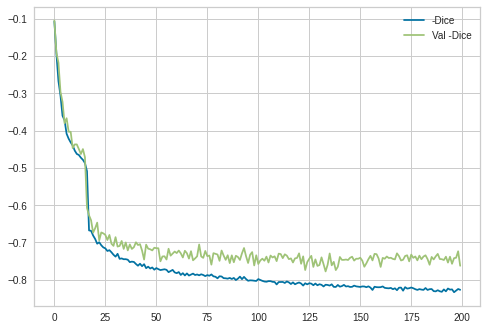

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 20s 417ms/step - loss: -0.1123 - iou: 0.0595 - dice_coef: 0.1123 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5897 - val_loss: -0.1126 - val_iou: 0.0597 - val_dice_coef: 0.1126 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4801


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 18s 392ms/step - loss: -0.2294 - iou: 0.1314 - dice_coef: 0.2301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8464 - val_loss: -0.1775 - val_iou: 0.0974 - val_dice_coef: 0.1775 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8970


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 18s 402ms/step - loss: -0.3215 - iou: 0.1934 - dice_coef: 0.3225 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9233 - val_loss: -0.2390 - val_iou: 0.1359 - val_dice_coef: 0.2390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9094


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 411ms/step - loss: -0.3927 - iou: 0.2454 - dice_coef: 0.3927 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9485 - val_loss: -0.3226 - val_iou: 0.1932 - val_dice_coef: 0.3226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9288


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 18s 398ms/step - loss: -0.4315 - iou: 0.2742 - dice_coef: 0.4285 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9537 - val_loss: -0.3966 - val_iou: 0.2499 - val_dice_coef: 0.3966 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9530


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 18s 394ms/step - loss: -0.4929 - iou: 0.3283 - dice_coef: 0.4929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9634 - val_loss: -0.4435 - val_iou: 0.2878 - val_dice_coef: 0.4435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9520


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 18s 399ms/step - loss: -0.5244 - iou: 0.3565 - dice_coef: 0.5241 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9663 - val_loss: -0.5018 - val_iou: 0.3381 - val_dice_coef: 0.5018 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9633


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 395ms/step - loss: -0.5539 - iou: 0.3870 - dice_coef: 0.5557 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9689 - val_loss: -0.5289 - val_iou: 0.3640 - val_dice_coef: 0.5289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9677


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 18s 400ms/step - loss: -0.5605 - iou: 0.3917 - dice_coef: 0.5606 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9692 - val_loss: -0.5376 - val_iou: 0.3719 - val_dice_coef: 0.5376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9630


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 18s 397ms/step - loss: -0.5887 - iou: 0.4185 - dice_coef: 0.5872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.5454 - val_iou: 0.3808 - val_dice_coef: 0.5454 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 18s 403ms/step - loss: -0.5943 - iou: 0.4260 - dice_coef: 0.5954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9720 - val_loss: -0.5705 - val_iou: 0.4054 - val_dice_coef: 0.5705 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9697


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 396ms/step - loss: -0.6166 - iou: 0.4467 - dice_coef: 0.6158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9737 - val_loss: -0.5809 - val_iou: 0.4139 - val_dice_coef: 0.5809 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 18s 404ms/step - loss: -0.6129 - iou: 0.4449 - dice_coef: 0.6130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9736 - val_loss: -0.5792 - val_iou: 0.4192 - val_dice_coef: 0.5792 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9721


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 405ms/step - loss: -0.6381 - iou: 0.4728 - dice_coef: 0.6391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -0.6080 - val_iou: 0.4439 - val_dice_coef: 0.6080 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6362 - iou: 0.4706 - dice_coef: 0.6369 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9752 - val_loss: -0.6167 - val_iou: 0.4502 - val_dice_coef: 0.6167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6443 - iou: 0.4795 - dice_coef: 0.6450 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9763 - val_loss: -0.6049 - val_iou: 0.4414 - val_dice_coef: 0.6049 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9696


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6509 - iou: 0.4849 - dice_coef: 0.6504 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -0.6282 - val_iou: 0.4629 - val_dice_coef: 0.6282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 18s 400ms/step - loss: -0.6613 - iou: 0.4986 - dice_coef: 0.6621 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -0.6298 - val_iou: 0.4688 - val_dice_coef: 0.6298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 18s 397ms/step - loss: -0.6622 - iou: 0.4980 - dice_coef: 0.6621 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9776 - val_loss: -0.6204 - val_iou: 0.4581 - val_dice_coef: 0.6204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 18s 405ms/step - loss: -0.6698 - iou: 0.5067 - dice_coef: 0.6695 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9778 - val_loss: -0.6336 - val_iou: 0.4711 - val_dice_coef: 0.6336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6788 - iou: 0.5164 - dice_coef: 0.6792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.6598 - val_iou: 0.4949 - val_dice_coef: 0.6598 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 18s 395ms/step - loss: -0.6841 - iou: 0.5208 - dice_coef: 0.6833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6644 - val_iou: 0.4992 - val_dice_coef: 0.6644 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 18s 402ms/step - loss: -0.6800 - iou: 0.5182 - dice_coef: 0.6794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6459 - val_iou: 0.4878 - val_dice_coef: 0.6459 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 401ms/step - loss: -0.6851 - iou: 0.5248 - dice_coef: 0.6851 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -0.6482 - val_iou: 0.4878 - val_dice_coef: 0.6482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 393ms/step - loss: -0.6963 - iou: 0.5379 - dice_coef: 0.6968 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.6593 - val_iou: 0.4973 - val_dice_coef: 0.6593 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 18s 406ms/step - loss: -0.6893 - iou: 0.5285 - dice_coef: 0.6892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.6596 - val_iou: 0.4986 - val_dice_coef: 0.6596 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 403ms/step - loss: -0.6961 - iou: 0.5383 - dice_coef: 0.6959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.6623 - val_iou: 0.5013 - val_dice_coef: 0.6623 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 409ms/step - loss: -0.7004 - iou: 0.5434 - dice_coef: 0.7005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.6605 - val_iou: 0.5020 - val_dice_coef: 0.6605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7086 - iou: 0.5521 - dice_coef: 0.7090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.6581 - val_iou: 0.5020 - val_dice_coef: 0.6581 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7095 - iou: 0.5542 - dice_coef: 0.7100 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -0.6602 - val_iou: 0.5019 - val_dice_coef: 0.6602 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 409ms/step - loss: -0.7132 - iou: 0.5568 - dice_coef: 0.7128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.6809 - val_iou: 0.5207 - val_dice_coef: 0.6809 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7141 - iou: 0.5604 - dice_coef: 0.7151 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -0.6696 - val_iou: 0.5155 - val_dice_coef: 0.6696 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7204 - iou: 0.5661 - dice_coef: 0.7195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.6873 - val_iou: 0.5327 - val_dice_coef: 0.6873 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7219 - iou: 0.5697 - dice_coef: 0.7224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.6914 - val_iou: 0.5313 - val_dice_coef: 0.6914 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 18s 409ms/step - loss: -0.7195 - iou: 0.5645 - dice_coef: 0.7190 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6940 - val_iou: 0.5390 - val_dice_coef: 0.6940 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7204 - iou: 0.5656 - dice_coef: 0.7195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.6760 - val_iou: 0.5217 - val_dice_coef: 0.6760 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7186 - iou: 0.5651 - dice_coef: 0.7188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.6812 - val_iou: 0.5298 - val_dice_coef: 0.6812 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7318 - iou: 0.5819 - dice_coef: 0.7317 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.7013 - val_iou: 0.5435 - val_dice_coef: 0.7013 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7313 - iou: 0.5797 - dice_coef: 0.7312 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7072 - val_iou: 0.5535 - val_dice_coef: 0.7072 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7285 - iou: 0.5787 - dice_coef: 0.7290 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.6981 - val_iou: 0.5460 - val_dice_coef: 0.6981 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7309 - iou: 0.5806 - dice_coef: 0.7313 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.6854 - val_iou: 0.5363 - val_dice_coef: 0.6854 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7335 - iou: 0.5828 - dice_coef: 0.7334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.6924 - val_iou: 0.5385 - val_dice_coef: 0.6924 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7390 - iou: 0.5920 - dice_coef: 0.7399 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6639 - val_iou: 0.5076 - val_dice_coef: 0.6639 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7373 - iou: 0.5889 - dice_coef: 0.7380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.7006 - val_iou: 0.5492 - val_dice_coef: 0.7006 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7389 - iou: 0.5900 - dice_coef: 0.7395 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.7034 - val_iou: 0.5522 - val_dice_coef: 0.7034 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7414 - iou: 0.5946 - dice_coef: 0.7422 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.6924 - val_iou: 0.5379 - val_dice_coef: 0.6924 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7493 - iou: 0.6030 - dice_coef: 0.7500 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.6929 - val_iou: 0.5438 - val_dice_coef: 0.6929 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7447 - iou: 0.5976 - dice_coef: 0.7453 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.6815 - val_iou: 0.5315 - val_dice_coef: 0.6815 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7480 - iou: 0.6015 - dice_coef: 0.7483 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.7054 - val_iou: 0.5530 - val_dice_coef: 0.7054 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 18s 393ms/step - loss: -0.7507 - iou: 0.6042 - dice_coef: 0.7510 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.7143 - val_iou: 0.5585 - val_dice_coef: 0.7143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7512 - iou: 0.6065 - dice_coef: 0.7512 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.7058 - val_iou: 0.5561 - val_dice_coef: 0.7058 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7551 - iou: 0.6037 - dice_coef: 0.7499 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.7156 - val_iou: 0.5640 - val_dice_coef: 0.7156 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7571 - iou: 0.6132 - dice_coef: 0.7578 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.7224 - val_iou: 0.5728 - val_dice_coef: 0.7224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 406ms/step - loss: -0.7525 - iou: 0.6074 - dice_coef: 0.7525 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.7013 - val_iou: 0.5523 - val_dice_coef: 0.7013 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 18s 407ms/step - loss: -0.7552 - iou: 0.6115 - dice_coef: 0.7551 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7326 - val_iou: 0.5807 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7589 - iou: 0.6161 - dice_coef: 0.7593 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7028 - val_iou: 0.5540 - val_dice_coef: 0.7028 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7566 - iou: 0.6136 - dice_coef: 0.7561 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.7057 - val_iou: 0.5578 - val_dice_coef: 0.7057 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7538 - iou: 0.6112 - dice_coef: 0.7541 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7135 - val_iou: 0.5643 - val_dice_coef: 0.7135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7653 - iou: 0.6239 - dice_coef: 0.7656 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7237 - val_iou: 0.5728 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7648 - iou: 0.6236 - dice_coef: 0.7648 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7186 - val_iou: 0.5692 - val_dice_coef: 0.7186 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7612 - iou: 0.6189 - dice_coef: 0.7610 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.7225 - val_iou: 0.5704 - val_dice_coef: 0.7225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7664 - iou: 0.6257 - dice_coef: 0.7669 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7055 - val_iou: 0.5623 - val_dice_coef: 0.7055 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 409ms/step - loss: -0.7613 - iou: 0.6199 - dice_coef: 0.7614 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7224 - val_iou: 0.5769 - val_dice_coef: 0.7224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7603 - iou: 0.6181 - dice_coef: 0.7603 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7101 - val_iou: 0.5643 - val_dice_coef: 0.7101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7666 - iou: 0.6268 - dice_coef: 0.7666 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.6980 - val_iou: 0.5558 - val_dice_coef: 0.6980 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7657 - iou: 0.6260 - dice_coef: 0.7660 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.6978 - val_iou: 0.5569 - val_dice_coef: 0.6978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7698 - iou: 0.6312 - dice_coef: 0.7698 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7133 - val_iou: 0.5729 - val_dice_coef: 0.7133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7717 - iou: 0.6335 - dice_coef: 0.7714 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7168 - val_iou: 0.5708 - val_dice_coef: 0.7168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 415ms/step - loss: -0.7737 - iou: 0.6350 - dice_coef: 0.7737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7025 - val_iou: 0.5579 - val_dice_coef: 0.7025 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7734 - iou: 0.6340 - dice_coef: 0.7734 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7007 - val_iou: 0.5551 - val_dice_coef: 0.7007 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7688 - iou: 0.6284 - dice_coef: 0.7686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7178 - val_iou: 0.5699 - val_dice_coef: 0.7178 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7777 - iou: 0.6412 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7207 - val_iou: 0.5784 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7744 - iou: 0.6393 - dice_coef: 0.7749 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7075 - val_iou: 0.5622 - val_dice_coef: 0.7075 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7665 - iou: 0.6265 - dice_coef: 0.7669 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7328 - val_iou: 0.5820 - val_dice_coef: 0.7328 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7848 - iou: 0.6479 - dice_coef: 0.7850 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.7167 - val_iou: 0.5710 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7722 - iou: 0.6339 - dice_coef: 0.7721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.7291 - val_iou: 0.5804 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7795 - iou: 0.6432 - dice_coef: 0.7802 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7234 - val_iou: 0.5793 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 18s 395ms/step - loss: -0.7761 - iou: 0.6380 - dice_coef: 0.7761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7292 - val_iou: 0.5836 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 18s 406ms/step - loss: -0.7839 - iou: 0.6484 - dice_coef: 0.7843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7376 - val_iou: 0.5871 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7772 - iou: 0.6408 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7175 - val_iou: 0.5723 - val_dice_coef: 0.7175 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 396ms/step - loss: -0.7775 - iou: 0.6421 - dice_coef: 0.7780 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7242 - val_iou: 0.5762 - val_dice_coef: 0.7242 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7822 - iou: 0.6475 - dice_coef: 0.7827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7394 - val_iou: 0.5906 - val_dice_coef: 0.7394 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 19s 413ms/step - loss: -0.7762 - iou: 0.6412 - dice_coef: 0.7769 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7164 - val_iou: 0.5748 - val_dice_coef: 0.7164 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7832 - iou: 0.6491 - dice_coef: 0.7837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7154 - val_iou: 0.5760 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7898 - iou: 0.6570 - dice_coef: 0.7898 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7227 - val_iou: 0.5762 - val_dice_coef: 0.7227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7837 - iou: 0.6499 - dice_coef: 0.7838 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7398 - val_iou: 0.5944 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 18s 397ms/step - loss: -0.7867 - iou: 0.6522 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7188 - val_iou: 0.5768 - val_dice_coef: 0.7188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7829 - iou: 0.6492 - dice_coef: 0.7827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7170 - val_iou: 0.5705 - val_dice_coef: 0.7170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 405ms/step - loss: -0.7879 - iou: 0.6544 - dice_coef: 0.7881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7118 - val_iou: 0.5690 - val_dice_coef: 0.7118 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7875 - iou: 0.6538 - dice_coef: 0.7875 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7242 - val_iou: 0.5817 - val_dice_coef: 0.7242 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7882 - iou: 0.6544 - dice_coef: 0.7878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7205 - val_iou: 0.5813 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7865 - iou: 0.6533 - dice_coef: 0.7864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7396 - val_iou: 0.5923 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 18s 402ms/step - loss: -0.7887 - iou: 0.6557 - dice_coef: 0.7888 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7236 - val_iou: 0.5816 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7918 - iou: 0.6592 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7226 - val_iou: 0.5785 - val_dice_coef: 0.7226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7877 - iou: 0.6549 - dice_coef: 0.7876 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7173 - val_iou: 0.5812 - val_dice_coef: 0.7173 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7911 - iou: 0.6604 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7258 - val_iou: 0.5847 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 406ms/step - loss: -0.7876 - iou: 0.6563 - dice_coef: 0.7877 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7460 - val_iou: 0.5999 - val_dice_coef: 0.7460 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7925 - iou: 0.6605 - dice_coef: 0.7925 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7239 - val_iou: 0.5871 - val_dice_coef: 0.7239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7975 - iou: 0.6595 - dice_coef: 0.7915 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7319 - val_iou: 0.5926 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7922 - iou: 0.6603 - dice_coef: 0.7924 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7376 - val_iou: 0.5944 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7914 - iou: 0.6592 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7180 - val_iou: 0.5787 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7926 - iou: 0.6609 - dice_coef: 0.7930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7487 - val_iou: 0.6012 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 407ms/step - loss: -0.7921 - iou: 0.6637 - dice_coef: 0.7922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7234 - val_iou: 0.5834 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7932 - iou: 0.6635 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7374 - val_iou: 0.5890 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 399ms/step - loss: -0.7949 - iou: 0.6642 - dice_coef: 0.7950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7207 - val_iou: 0.5831 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 398ms/step - loss: -0.7889 - iou: 0.6579 - dice_coef: 0.7889 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7319 - val_iou: 0.5859 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 18s 408ms/step - loss: -0.7973 - iou: 0.6689 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7251 - val_iou: 0.5793 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 18s 403ms/step - loss: -0.7957 - iou: 0.6673 - dice_coef: 0.7960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7205 - val_iou: 0.5832 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7962 - iou: 0.6667 - dice_coef: 0.7965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7305 - val_iou: 0.5894 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8003 - iou: 0.6745 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7307 - val_iou: 0.5908 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 18s 407ms/step - loss: -0.7949 - iou: 0.6665 - dice_coef: 0.7952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7232 - val_iou: 0.5839 - val_dice_coef: 0.7232 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 18s 400ms/step - loss: -0.7998 - iou: 0.6696 - dice_coef: 0.7994 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7309 - val_iou: 0.5928 - val_dice_coef: 0.7309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 404ms/step - loss: -0.7982 - iou: 0.6702 - dice_coef: 0.7982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7251 - val_iou: 0.5846 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8013 - iou: 0.6724 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7302 - val_iou: 0.5877 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 394ms/step - loss: -0.7950 - iou: 0.6657 - dice_coef: 0.7950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7407 - val_iou: 0.5954 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8025 - iou: 0.6747 - dice_coef: 0.8032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7182 - val_iou: 0.5799 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8004 - iou: 0.6740 - dice_coef: 0.8005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7238 - val_iou: 0.5869 - val_dice_coef: 0.7238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8043 - iou: 0.6767 - dice_coef: 0.8045 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7282 - val_iou: 0.5845 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8074 - iou: 0.6822 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7411 - val_iou: 0.6011 - val_dice_coef: 0.7411 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8023 - iou: 0.6759 - dice_coef: 0.8026 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7311 - val_iou: 0.5889 - val_dice_coef: 0.7311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 401ms/step - loss: -0.7946 - iou: 0.6664 - dice_coef: 0.7945 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7525 - val_iou: 0.6074 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8020 - iou: 0.6764 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7494 - val_iou: 0.6026 - val_dice_coef: 0.7494 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8015 - iou: 0.6733 - dice_coef: 0.8016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7479 - val_iou: 0.6034 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8023 - iou: 0.6758 - dice_coef: 0.8029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7313 - val_iou: 0.5900 - val_dice_coef: 0.7313 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8014 - iou: 0.6751 - dice_coef: 0.8017 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7245 - val_iou: 0.5860 - val_dice_coef: 0.7245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8072 - iou: 0.6815 - dice_coef: 0.8071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7356 - val_iou: 0.5928 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8013 - iou: 0.6739 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7476 - val_iou: 0.6019 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8041 - iou: 0.6782 - dice_coef: 0.8034 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7340 - val_iou: 0.5980 - val_dice_coef: 0.7340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8035 - iou: 0.6772 - dice_coef: 0.8041 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7391 - val_iou: 0.5997 - val_dice_coef: 0.7391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8017 - iou: 0.6754 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7388 - val_iou: 0.6020 - val_dice_coef: 0.7388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8096 - iou: 0.6851 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7572 - val_iou: 0.6135 - val_dice_coef: 0.7572 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8023 - iou: 0.6756 - dice_coef: 0.8024 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7144 - val_iou: 0.5764 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8057 - iou: 0.6822 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7362 - val_iou: 0.5949 - val_dice_coef: 0.7362 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8063 - iou: 0.6812 - dice_coef: 0.8063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7212 - val_iou: 0.5812 - val_dice_coef: 0.7212 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8093 - iou: 0.6838 - dice_coef: 0.8091 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7456 - val_iou: 0.6016 - val_dice_coef: 0.7456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8064 - iou: 0.6820 - dice_coef: 0.8068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7349 - val_iou: 0.5964 - val_dice_coef: 0.7349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 412ms/step - loss: -0.8075 - iou: 0.6825 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7483 - val_iou: 0.6041 - val_dice_coef: 0.7483 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8066 - iou: 0.6796 - dice_coef: 0.8060 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7391 - val_iou: 0.5955 - val_dice_coef: 0.7391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8061 - iou: 0.6810 - dice_coef: 0.8060 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7455 - val_iou: 0.6015 - val_dice_coef: 0.7455 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8102 - iou: 0.6855 - dice_coef: 0.8106 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7428 - val_iou: 0.6004 - val_dice_coef: 0.7428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8084 - iou: 0.6851 - dice_coef: 0.8082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7253 - val_iou: 0.5868 - val_dice_coef: 0.7253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8103 - iou: 0.6856 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7250 - val_iou: 0.5881 - val_dice_coef: 0.7250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8125 - iou: 0.6888 - dice_coef: 0.8120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7644 - val_iou: 0.6217 - val_dice_coef: 0.7644 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8087 - iou: 0.6836 - dice_coef: 0.8082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7361 - val_iou: 0.5939 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8134 - iou: 0.6888 - dice_coef: 0.8134 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7393 - val_iou: 0.5987 - val_dice_coef: 0.7393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8176 - iou: 0.6877 - dice_coef: 0.8107 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7322 - val_iou: 0.5924 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 431ms/step - loss: -0.8098 - iou: 0.6872 - dice_coef: 0.8100 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7452 - val_iou: 0.6006 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8075 - iou: 0.6824 - dice_coef: 0.8073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7373 - val_iou: 0.5976 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8104 - iou: 0.6873 - dice_coef: 0.8104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7271 - val_iou: 0.5881 - val_dice_coef: 0.7271 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8111 - iou: 0.6871 - dice_coef: 0.8114 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7551 - val_iou: 0.6121 - val_dice_coef: 0.7551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8127 - iou: 0.6909 - dice_coef: 0.8131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7525 - val_iou: 0.6097 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8135 - iou: 0.6909 - dice_coef: 0.8135 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7355 - val_iou: 0.5938 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8116 - iou: 0.6898 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7497 - val_iou: 0.6057 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8123 - iou: 0.6900 - dice_coef: 0.8126 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7344 - val_iou: 0.5964 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8131 - iou: 0.6926 - dice_coef: 0.8136 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7674 - val_iou: 0.6283 - val_dice_coef: 0.7674 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9852


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8127 - iou: 0.6916 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7515 - val_iou: 0.6054 - val_dice_coef: 0.7515 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8161 - iou: 0.6957 - dice_coef: 0.8163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7536 - val_iou: 0.6108 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 394ms/step - loss: -0.8161 - iou: 0.6934 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7301 - val_iou: 0.5914 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8140 - iou: 0.6911 - dice_coef: 0.8134 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7287 - val_iou: 0.5853 - val_dice_coef: 0.7287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8111 - iou: 0.6901 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7537 - val_iou: 0.6090 - val_dice_coef: 0.7537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8101 - iou: 0.6864 - dice_coef: 0.8102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7621 - val_iou: 0.6182 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8201 - iou: 0.6986 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7481 - val_iou: 0.6063 - val_dice_coef: 0.7481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8163 - iou: 0.6948 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7500 - val_iou: 0.6078 - val_dice_coef: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 395ms/step - loss: -0.8172 - iou: 0.6947 - dice_coef: 0.8169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7266 - val_iou: 0.5843 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 411ms/step - loss: -0.8130 - iou: 0.6918 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7260 - val_iou: 0.5903 - val_dice_coef: 0.7260 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8197 - iou: 0.6998 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7358 - val_iou: 0.5994 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8143 - iou: 0.6931 - dice_coef: 0.8145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7334 - val_iou: 0.5946 - val_dice_coef: 0.7334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 407ms/step - loss: -0.8213 - iou: 0.7014 - dice_coef: 0.8215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7532 - val_iou: 0.6105 - val_dice_coef: 0.7532 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8212 - iou: 0.7022 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7409 - val_iou: 0.6033 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8109 - iou: 0.6890 - dice_coef: 0.8107 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7238 - val_iou: 0.5864 - val_dice_coef: 0.7238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8189 - iou: 0.6979 - dice_coef: 0.8192 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7630 - val_iou: 0.6206 - val_dice_coef: 0.7630 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8167 - iou: 0.6964 - dice_coef: 0.8169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7341 - val_iou: 0.5909 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8171 - iou: 0.6967 - dice_coef: 0.8181 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7453 - val_iou: 0.6041 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8175 - iou: 0.6973 - dice_coef: 0.8176 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7601 - val_iou: 0.6162 - val_dice_coef: 0.7601 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8177 - iou: 0.6963 - dice_coef: 0.8178 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7708 - val_iou: 0.6304 - val_dice_coef: 0.7708 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9853


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8232 - iou: 0.7050 - dice_coef: 0.8231 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7337 - val_iou: 0.5937 - val_dice_coef: 0.7337 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 409ms/step - loss: -0.8221 - iou: 0.7031 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7319 - val_iou: 0.5919 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8193 - iou: 0.7022 - dice_coef: 0.8200 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7250 - val_iou: 0.5848 - val_dice_coef: 0.7250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8220 - iou: 0.7025 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7223 - val_iou: 0.5828 - val_dice_coef: 0.7223 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 412ms/step - loss: -0.8199 - iou: 0.7005 - dice_coef: 0.8203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7425 - val_iou: 0.5984 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8191 - iou: 0.7007 - dice_coef: 0.8193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7282 - val_iou: 0.5851 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 403ms/step - loss: -0.8163 - iou: 0.6969 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7356 - val_iou: 0.5917 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8242 - iou: 0.7076 - dice_coef: 0.8244 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7295 - val_iou: 0.5911 - val_dice_coef: 0.7295 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8228 - iou: 0.7034 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7556 - val_iou: 0.6120 - val_dice_coef: 0.7556 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 399ms/step - loss: -0.8225 - iou: 0.7040 - dice_coef: 0.8226 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7475 - val_iou: 0.6046 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 18s 404ms/step - loss: -0.8213 - iou: 0.7031 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7353 - val_iou: 0.5963 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8213 - iou: 0.7017 - dice_coef: 0.8210 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7321 - val_iou: 0.5919 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8221 - iou: 0.7024 - dice_coef: 0.8217 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7333 - val_iou: 0.6002 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 18s 398ms/step - loss: -0.8216 - iou: 0.7043 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7286 - val_iou: 0.5919 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 18s 397ms/step - loss: -0.8198 - iou: 0.7014 - dice_coef: 0.8199 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7450 - val_iou: 0.6057 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 405ms/step - loss: -0.8243 - iou: 0.7084 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7467 - val_iou: 0.6051 - val_dice_coef: 0.7467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 402ms/step - loss: -0.8263 - iou: 0.7088 - dice_coef: 0.8263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7335 - val_iou: 0.5953 - val_dice_coef: 0.7335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8314 - iou: 0.7077 - dice_coef: 0.8249 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7477 - val_iou: 0.6050 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8218 - iou: 0.7032 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7396 - val_iou: 0.5952 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 18s 400ms/step - loss: -0.8207 - iou: 0.7028 - dice_coef: 0.8204 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7619 - val_iou: 0.6204 - val_dice_coef: 0.7619 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 18s 410ms/step - loss: -0.8261 - iou: 0.7092 - dice_coef: 0.8265 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7305 - val_iou: 0.5944 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 18s 406ms/step - loss: -0.8253 - iou: 0.7097 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7422 - val_iou: 0.6054 - val_dice_coef: 0.7422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 18s 396ms/step - loss: -0.8216 - iou: 0.7036 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7314 - val_iou: 0.5943 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 18s 401ms/step - loss: -0.8278 - iou: 0.7118 - dice_coef: 0.8282 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7330 - val_iou: 0.5918 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 18s 408ms/step - loss: -0.8235 - iou: 0.7046 - dice_coef: 0.8236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7588 - val_iou: 0.6182 - val_dice_coef: 0.7588 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


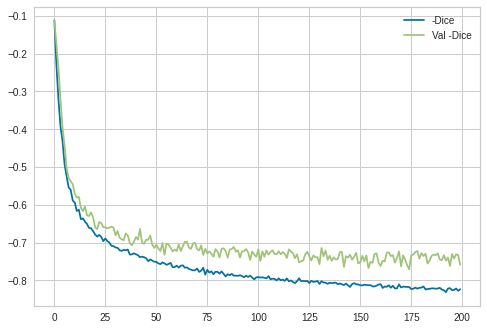

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [8,16,32,64,128]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    print('File exists')

  tf.keras.backend.clear_session()

  seg_model = create_model(phi_units)

  seg_model.compile(optimizer=Adam(lr=1e-4),
                    loss={'output':dice_coef_loss},
                    metrics = metrics)

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  # test_t = df_test_images['nerve_name'].to_list()
  template = 'there is nerve: {}\t Dice: {}\t AUC: {}'
  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  there_is_nerve = []
  show = True
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = cv2.resize(cv2.imread(path_file),(height,width))
    mask = cv2.resize(cv2.imread(mask_file,0),(height,width)).reshape(-1,)
    if mask.sum()==0:
      there_is_nerve.append(False)
    else:
      there_is_nerve.append(True)
      mask = mask/mask.max()
      mask[mask >= 0.5] = 1.
      mask[mask <0.5] = 0.
      if show:
        print('+++++++++++++++++++++++++++++++++++++')
        print(np.unique(mask))
        print('+++++++++++++++++++++++++++++++++++++')
        show = False
    # print(np.unique(mask))
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1,zero_division=0))
    try:
      AUC.append(roc_auc_score(mask,mask_est))
    except:
      AUC.append('null')

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.savefig(basepath+'/Boxplot_all')
  # plt.show()

  # for name_nerve in ['ciatico','cubital','femoral','mediano']:
  #   Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.title(name_nerve)
  # plt.savefig(basepath+'/Boxplot')
  # plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results_Unet results* results.xlsx

  adding: results_a-1_phi-units-128/ (stored 0%)
  adding: results_a-1_phi-units-128/results.joblib (deflated 69%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/keras_metadata.pb (deflated 94%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.index (deflated 75%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-128/model.h5 (deflated 11%)
  adding: results_a-1_phi-units-128/LearningCurve.png (deflated 6%)
  adding: results_a-1_phi-units-16/ (stored 0%)
  adding: results_a-1_phi-units-16/results.joblib (deflated 77%)
  adding: results_a-1_phi-units-16/Model_Checkpoint/ (store